In [1]:
# Imports
from lsst.daf.persistence import Butler

from astropy.visualization import make_lupton_rgb
import functools
import lsst.afw.image as afwImage
import lsst.geom as geom
import lsst.meas.base.measurementInvestigationLib as mil
import matplotlib.pyplot as plt
import modelling_research.dc2 as dc2
import modelling_research.meas_model as mrMeas
import modelling_research.multiprofit_task as mrTask
import modelling_research.tables as mrTables
import modelling_research.plot_matches as mrPlotMatches
import numpy as np
import matplotlib as mpl
import seaborn as sns

In [2]:
# Plot settings
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'bottom'
mpl.rcParams['figure.figsize'] = 10, 20
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})
sns.set_style('dark')

# Bands and colour balance
bands_weights = {'i': 1.0, 'r': 1.191, 'g': 2.249}

# Reference band for when we need to pick one
band_ref = 'r'
band_fit = 'griz'

In [3]:
# Construct Source Meeasurements from a cat
def get_source_meas_all(bbox, cat, column_mag, mag_min, wcs, column_ra=None, column_dec=None, zeropoint=None):
    if column_ra is None:
        column_ra = 'coord_ra'
    if column_dec is None:
        column_dec = 'coord_dec'
    bbox_begin = bbox.getBegin()
    (ra_c2, dec_c1), (ra_c1, dec_c2) = (
        wcs.pixelToSky(geom.Point2D(x))
        for x in (bbox_begin, bbox.getEnd())
    )
    ra_t, dec_t = cat[column_ra], cat[column_dec]
    mag = cat[column_mag]
    if zeropoint is not None:
        mag = -2.5*np.log10(mag) + zeropoint
    sources_within = np.where((ra_t > ra_c1) & (ra_t < ra_c2) & (dec_t > dec_c1) & (dec_t < dec_c2) & (mag < mag_min))[0]
    sources_input = []
    for idx in sources_within:
        cx, cy = wcs.skyToPixel(geom.SpherePoint(ra_t[idx], dec_t[idx], geom.radians)) - bbox_begin
        source = mrMeas.Source(
            idx_row=idx,
            measurements=[
                mrMeas.Measurement(
                    mag=mag[idx], ellipse=mrMeas.Ellipse(centroid=mrMeas.Centroid(x=cx, y=cy), shape=None),
                )
            ]
        )
        sources_input.append(source)
    return sources_input

In [9]:
# Load the original and Scarlet DC2 repo
name_old = 'Old'
name_scarlet = 'Scarlet'
paths = {
    name_old: '/datasets/DC2/repoRun2.2i/rerun/w_2020_32/DM-26287/multi',
    name_scarlet: '/project/dtaranu/dc2/scarlet/2020-12-01/ugrizy',
}
butlers = {name: Butler(path) for name, path in paths.items()}

In [10]:
# Read the central patch (DC2 is 7x7 vs HSC's 9x9 patches)
dataId = dict(tract=3828, patch='3,3')
catexps = {}
cat_refs = {}
wcs_refs = {}
for name, butler in butlers.items():
    catexps_b = {}
    for band in bands_weights:
        cat = butler.get('deepCoadd_meas', **dataId, filter=band)
        exp = butler.get('deepCoadd_calexp', **dataId, filter=band)
        exp.variance.array = 1./np.sqrt(exp.variance.array)
        catexps_b[band] = mrMeas.CatExp(band=band, cat=cat, img=exp.image, siginv=exp.variance, model=None)
        if band == band_ref:
            wcs_refs[name] = exp.getWcs()
    catexps[name] = catexps_b
    cat_refs[name] = butler.get('deepCoadd_ref', **dataId)

In [11]:
# Load MultiProFit fits
namepaths = {
    name_old: (name_old, '/project/dtaranu/dc2/2020-11-16/'),
    f'{name_scarlet}_sibSub': (name_scarlet, '/project/dtaranu/dc2/scarlet/2020-11-16_mpf-siblingSub/'),
    f'{name_scarlet}_NR': (name_scarlet, '/project/dtaranu/dc2/scarlet/2020-11-16_mpf-noiseReplacer/'),
}
cats_mpf = {
    name_mpf: mrTables.read_split_cat_fits(f'{namepath[1]}{band_fit}/mpf_dc2_griz_3828_3,3_mag.fits')
    for name_mpf, namepath in namepaths.items()
}

In [12]:
# Define measurements (models)
models_meas = {
    'Base PSF': mrMeas.Model('Base PSF', 'base_PsfFlux', 0),
    'MPF Sersic': mrMeas.Model('MPF Sersic', 'multiprofit_mg8serbpx', 1),
    name_scarlet: mrMeas.Model('Scarlet', 'scarlet', 0),
}
models_meas = {
    name_old: {name_model: model for name_model, model in models_meas.items() if name_model != name_scarlet},
    name_scarlet: models_meas,
}

In [13]:
# Match against DC2
butler_ref = dc2.get_refcat(make=False)
filters_single = ('g', 'r', 'i', 'z')
filters_multi = ('griz',)
band_multi = filters_multi[0]
band_ref = 'r'
get_path_cats = functools.partial(dc2.get_path_cats, patches_regex='[3],[3]')
cats_dc2 = {
    name: dc2.match_refcat_dc2(
        butler_ref, match_afw=False,
        tracts={3828: (path, '2.2i'),}, butlers_dc2={'2.2i': butlers[name_butler]},
        filters_single=filters_single, filters_multi=filters_multi, func_path=get_path_cats,
    )
    for name, (name_butler, path) in namepaths.items()
}

Loading tract 3828 band r
Loading 1 files from path=/project/dtaranu/dc2/2020-11-16/r/mpf_dc2_r_3828_[3],[3]_mag.fits
Loaded in 22.8s; loading 3,3 (1/1) and matching file=/project/dtaranu/dc2/2020-11-16/r/mpf_dc2_r_3828_3,3_mag.fits; len(cat,truth)=16772,103108
Loading tract 3828 band g
Loading 1 files from path=/project/dtaranu/dc2/2020-11-16/g/mpf_dc2_g_3828_[3],[3]_mag.fits
Loaded in 2.6s; loading 3,3 (1/1) file=/project/dtaranu/dc2/2020-11-16/g/mpf_dc2_g_3828_3,3_mag.fits; len(cat,truth)=16772,103108
Loading tract 3828 band i
Loading 1 files from path=/project/dtaranu/dc2/2020-11-16/i/mpf_dc2_i_3828_[3],[3]_mag.fits
Loaded in 2.4s; loading 3,3 (1/1) file=/project/dtaranu/dc2/2020-11-16/i/mpf_dc2_i_3828_3,3_mag.fits; len(cat,truth)=16772,103108
Loading tract 3828 band z
Loading 1 files from path=/project/dtaranu/dc2/2020-11-16/z/mpf_dc2_z_3828_[3],[3]_mag.fits
Loaded in 2.7s; loading 3,3 (1/1) file=/project/dtaranu/dc2/2020-11-16/z/mpf_dc2_z_3828_3,3_mag.fits; len(cat,truth)=16772,1

N=0 sky object matches
Rematched 181/102890; 11519 originally and 11331 rematched already matched
N=0sky object matches after rematching
DC2 3828 Resolved g-band, Base PSF, N=1891


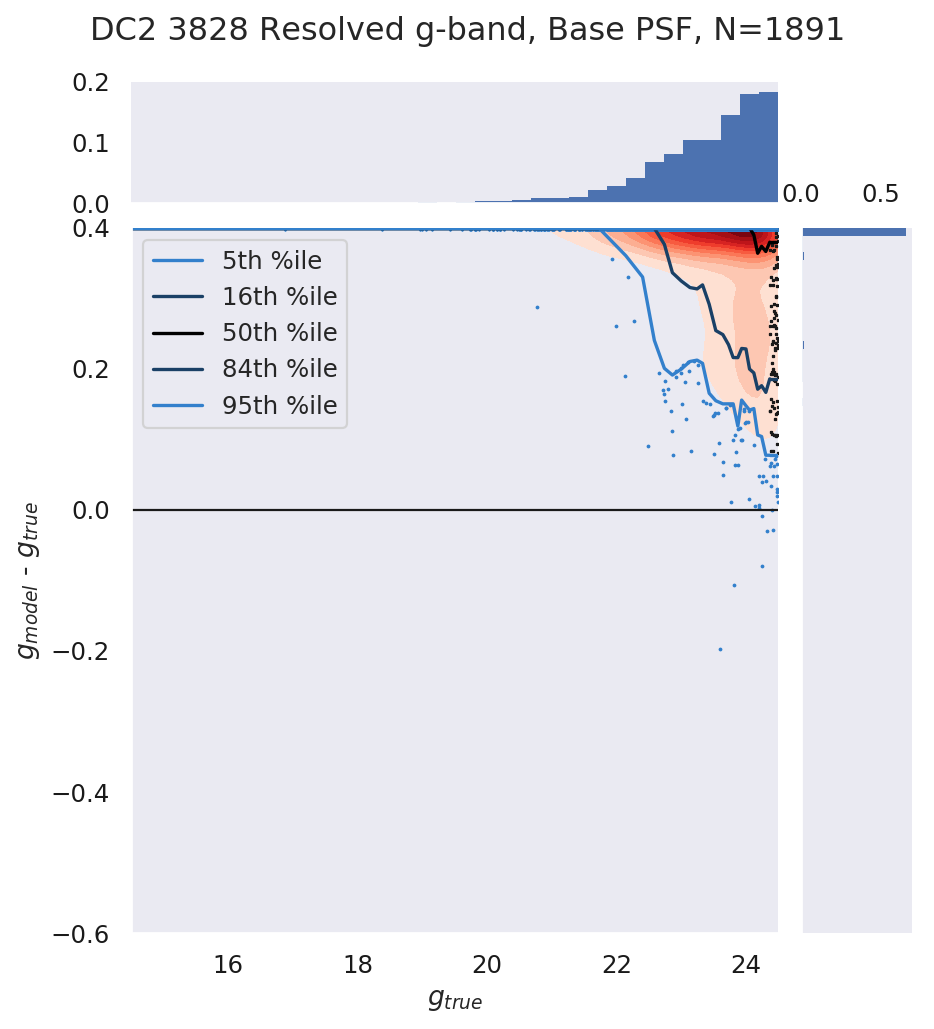

DC2 3828 Resolved r-band, Base PSF, N=2968


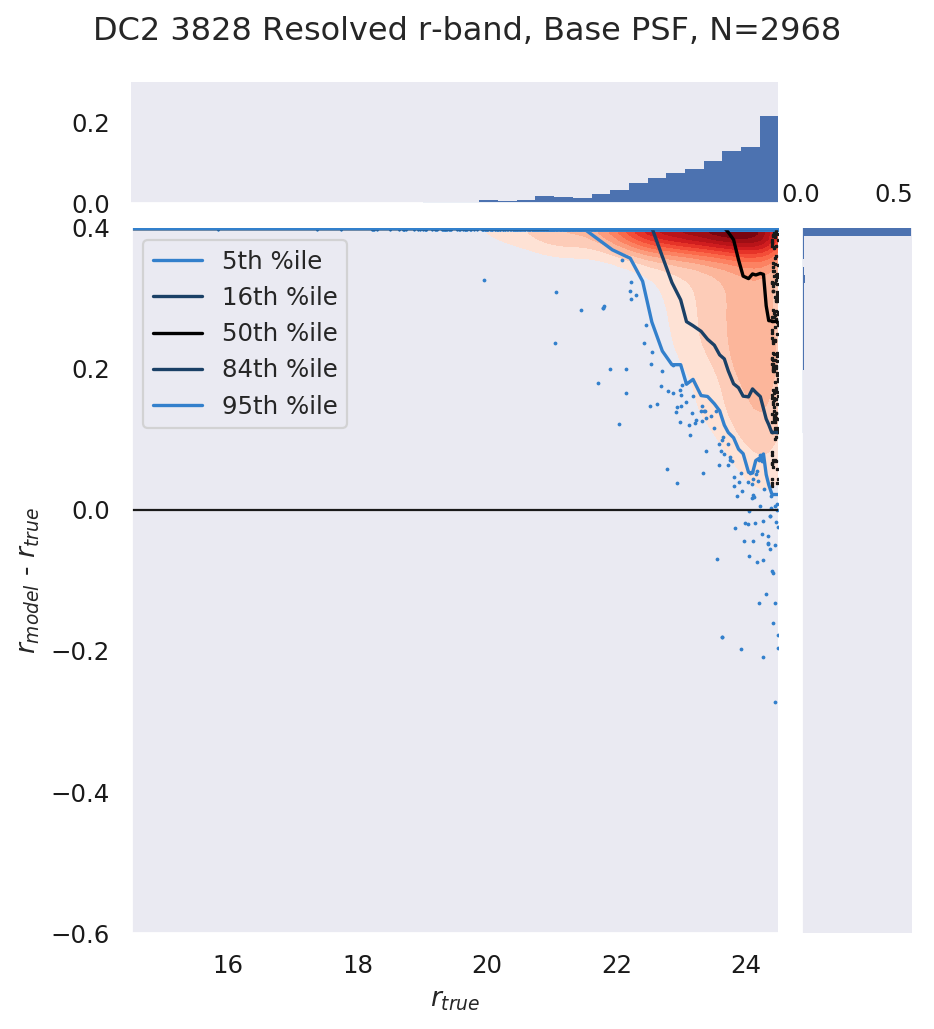

DC2 3828 Resolved i-band, Base PSF, N=4237


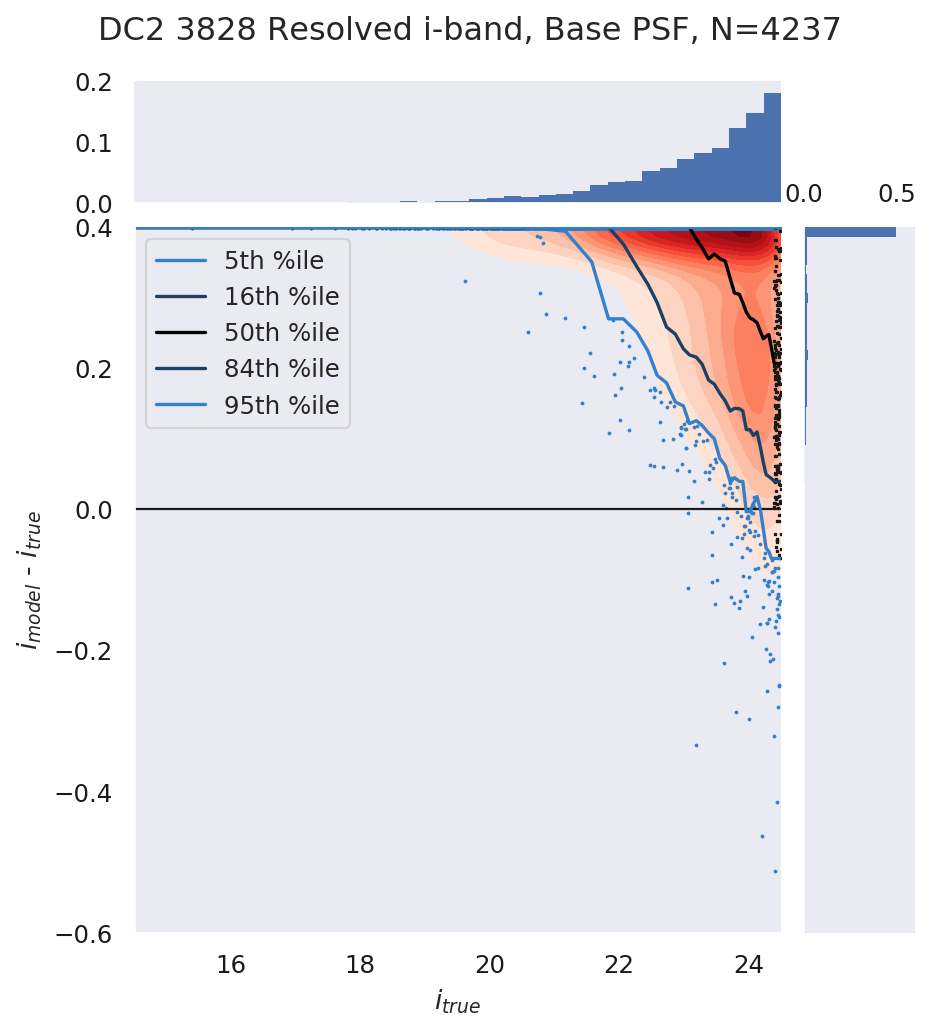

DC2 3828 Resolved z-band, Base PSF, N=5355


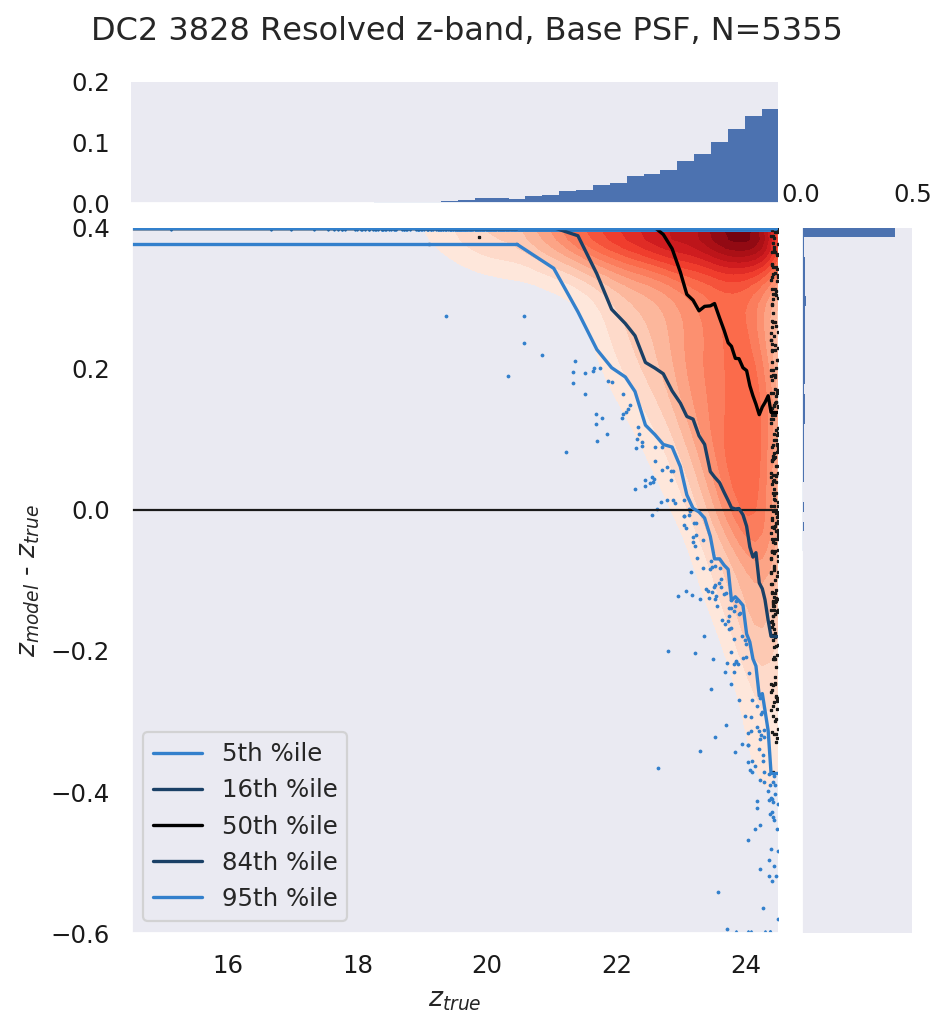

DC2 3828 Resolved g-r, Base PSF, N=2968


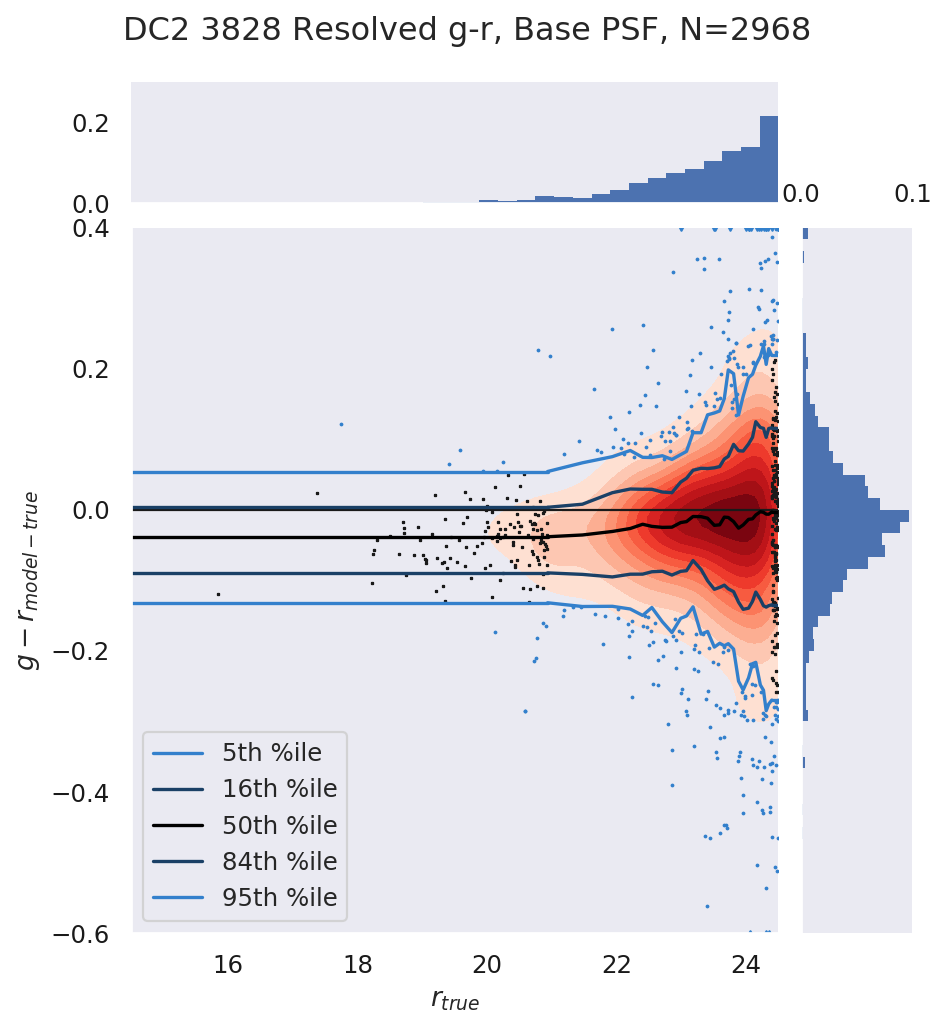

DC2 3828 Resolved r-i, Base PSF, N=2968


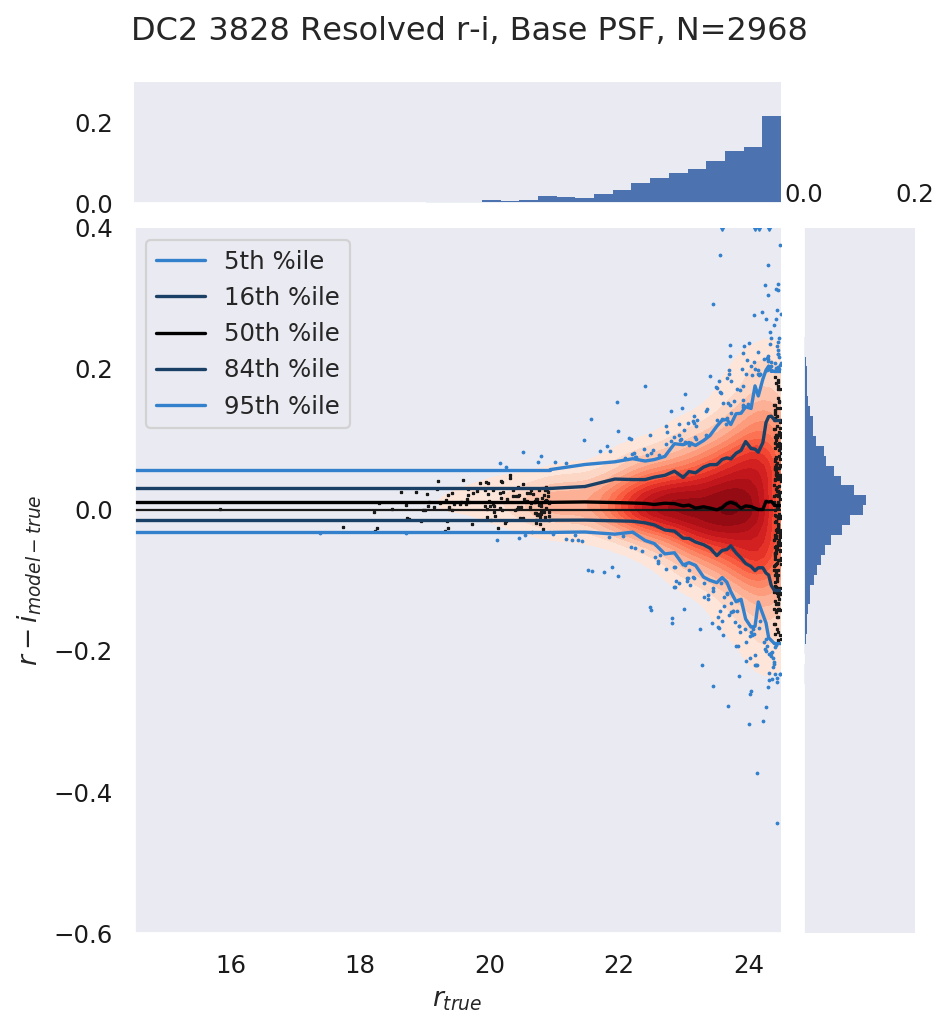

DC2 3828 Resolved i-z, Base PSF, N=2968


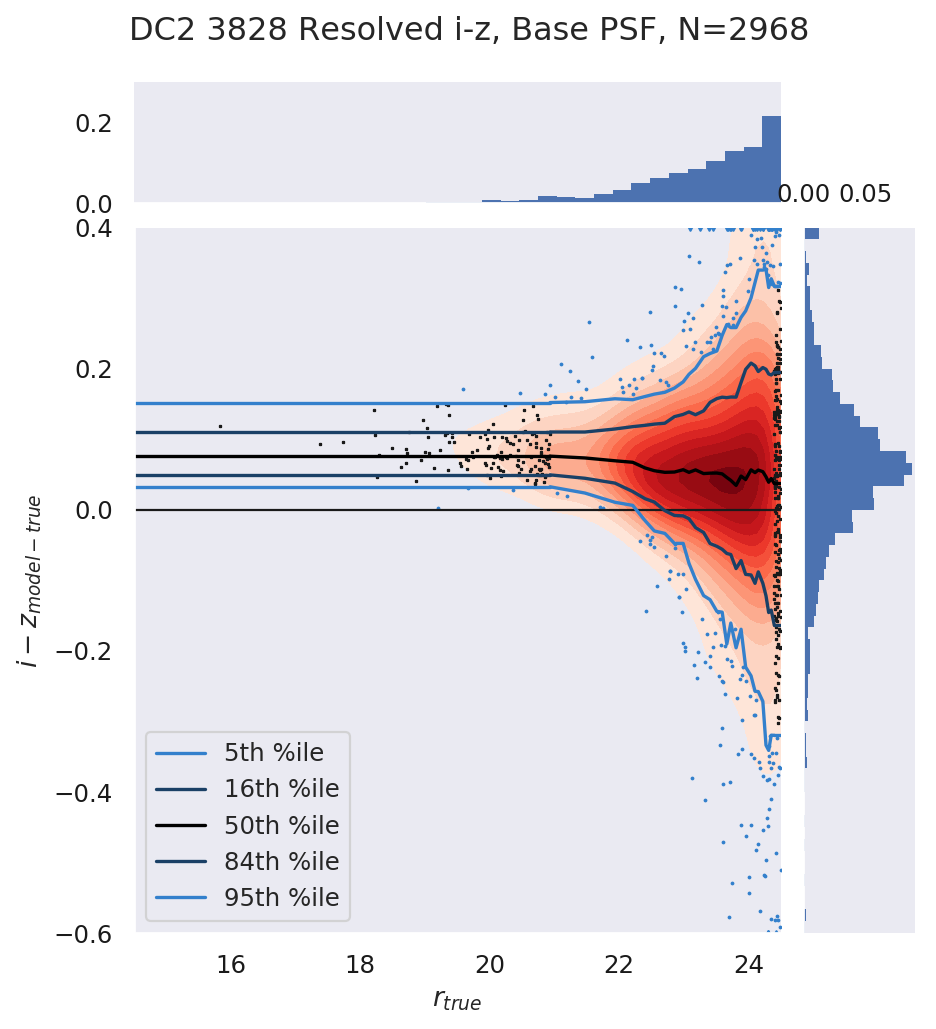

DC2 3828 Resolved g-band, MPF Sersic, N=1891


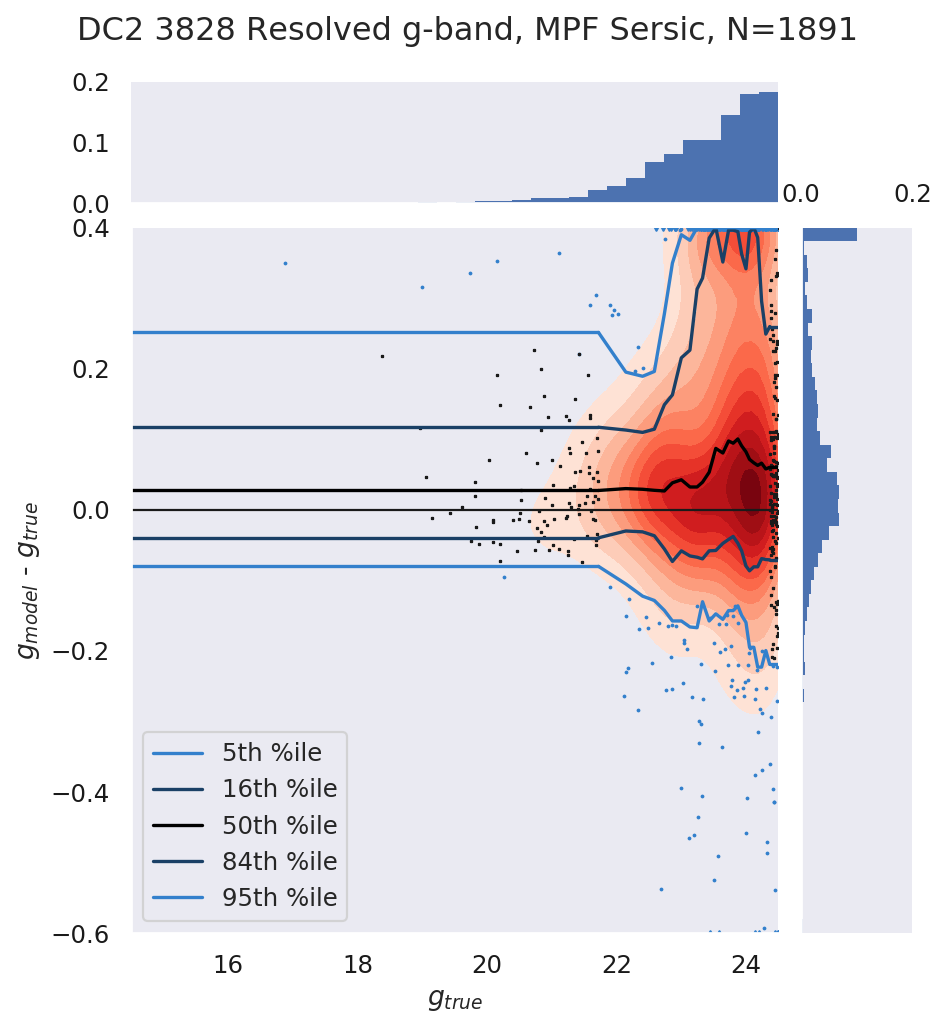

DC2 3828 Resolved g-band, MPF Sersic(griz), N=1891


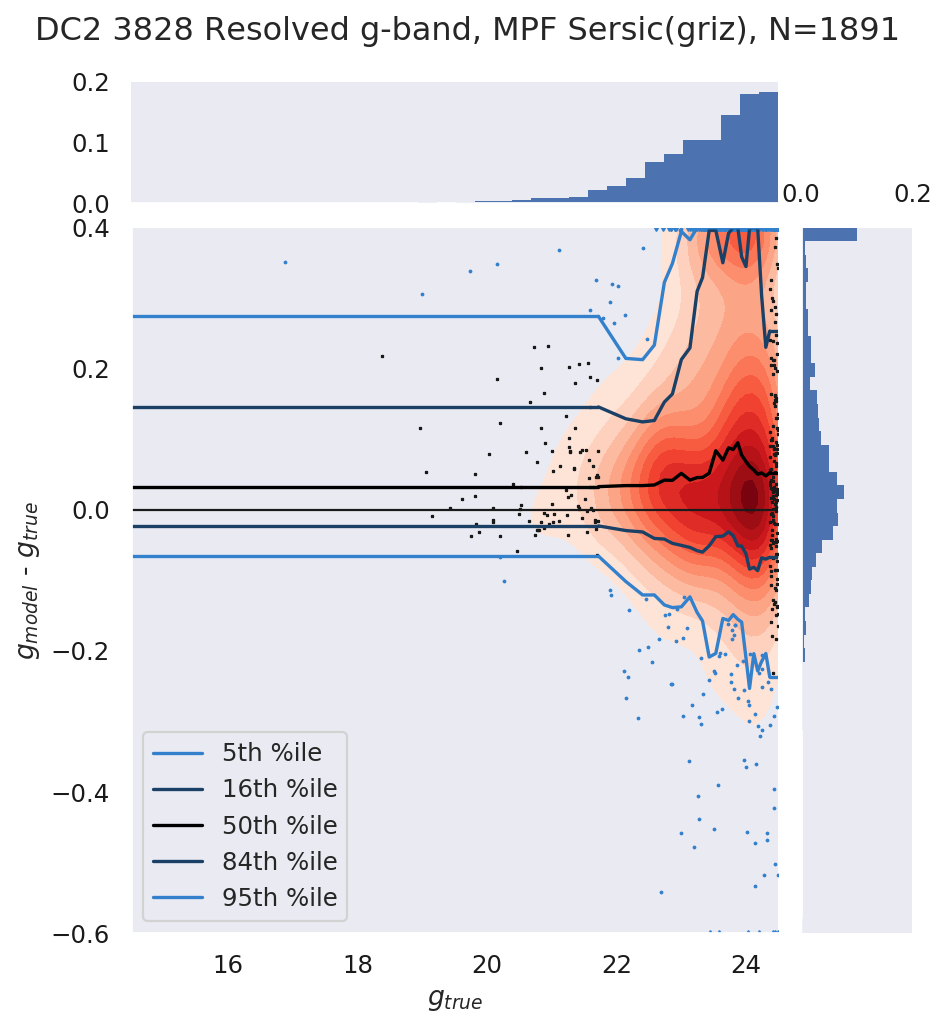

DC2 3828 Resolved r-band, MPF Sersic, N=2968


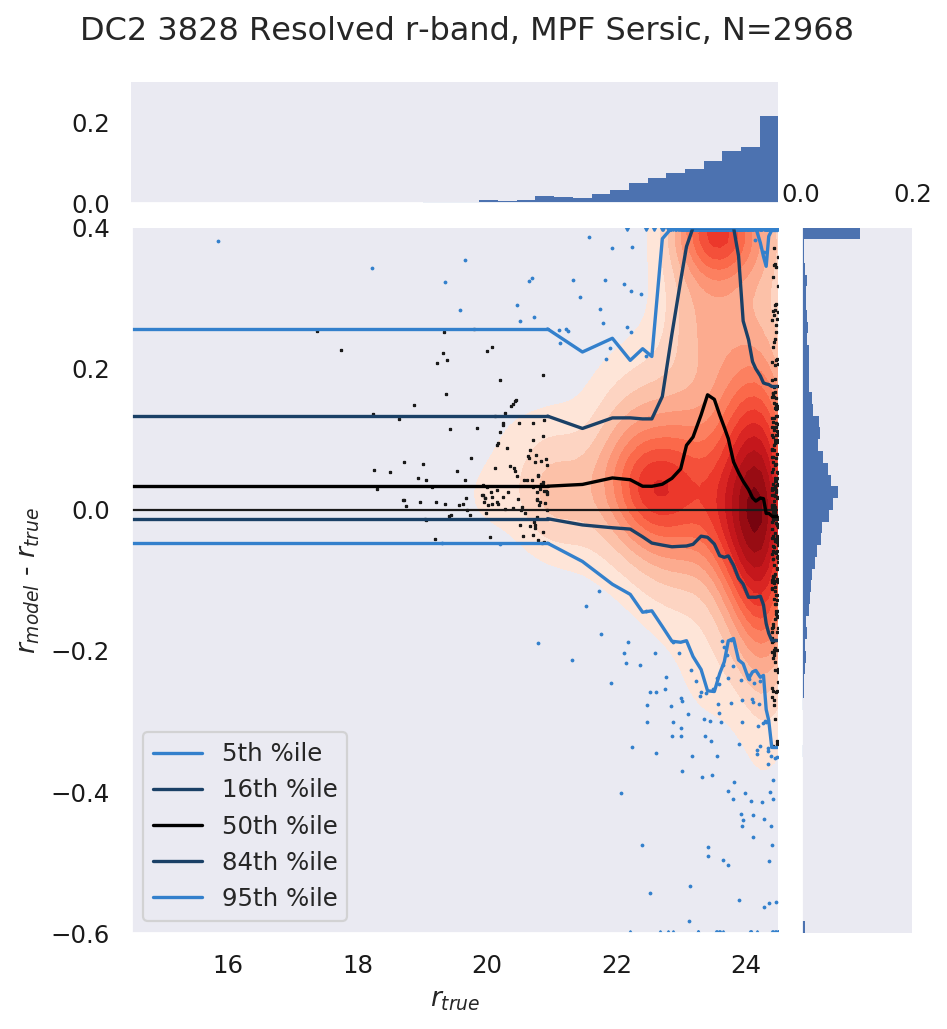

DC2 3828 Resolved r-band, MPF Sersic(griz), N=2968


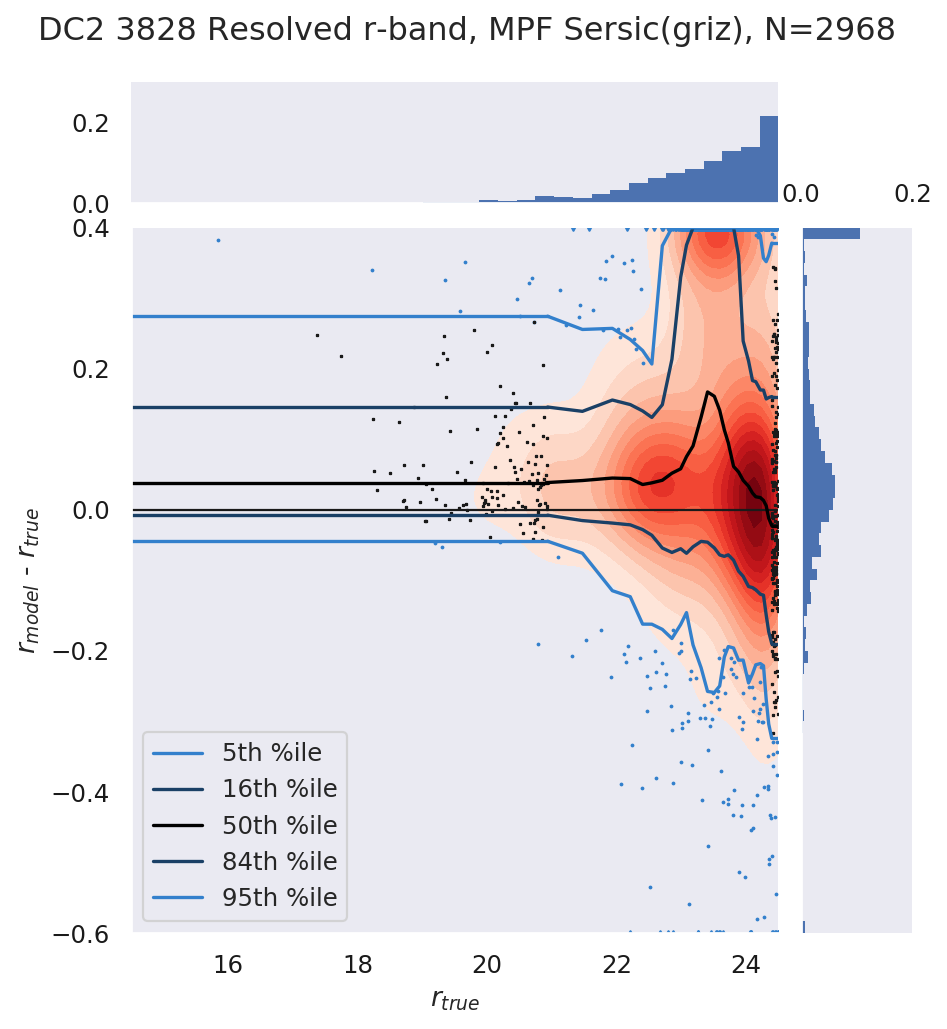

DC2 3828 Resolved i-band, MPF Sersic, N=4237


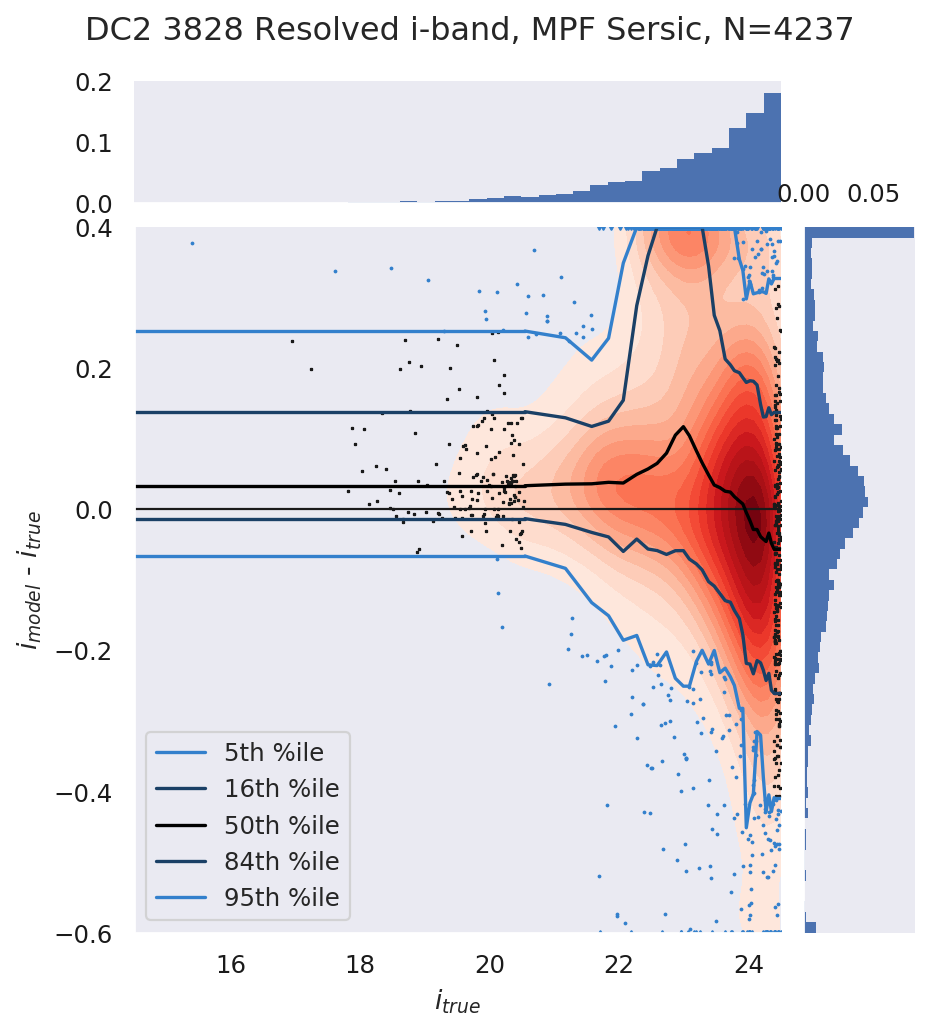

DC2 3828 Resolved i-band, MPF Sersic(griz), N=4237


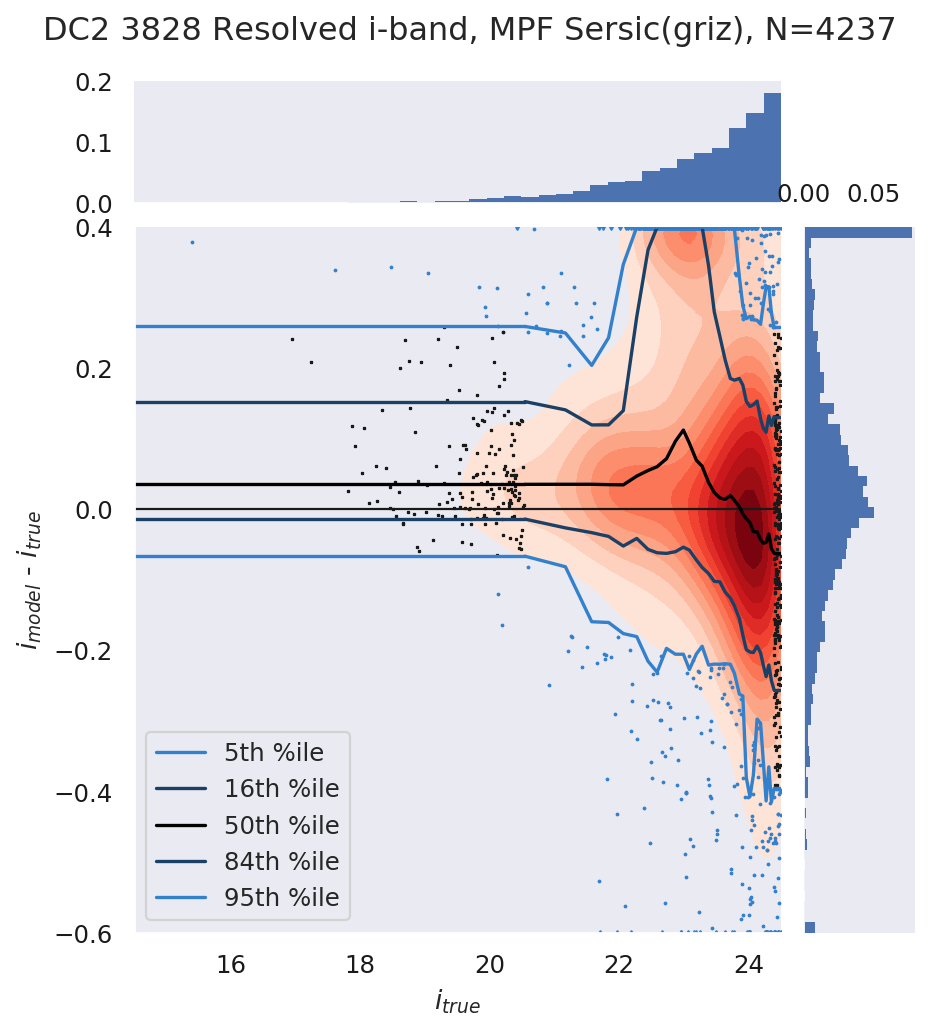

DC2 3828 Resolved z-band, MPF Sersic, N=5355


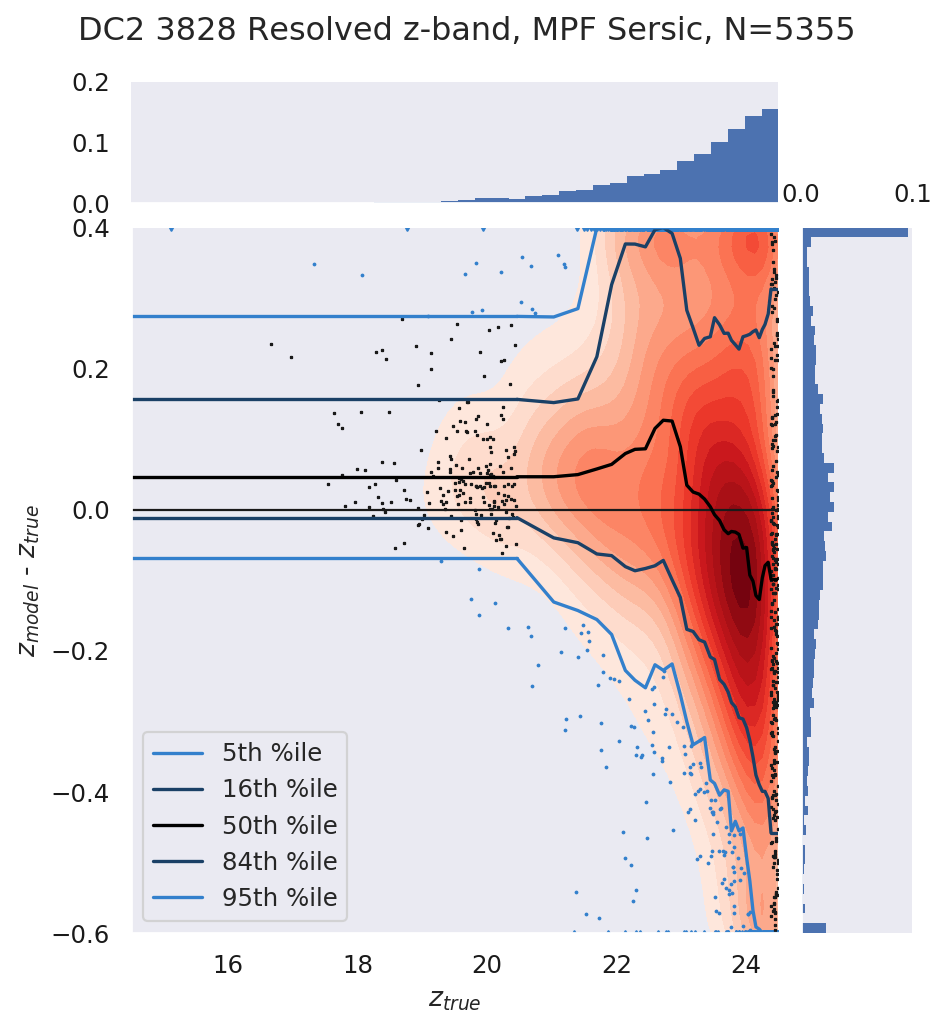

DC2 3828 Resolved z-band, MPF Sersic(griz), N=5355


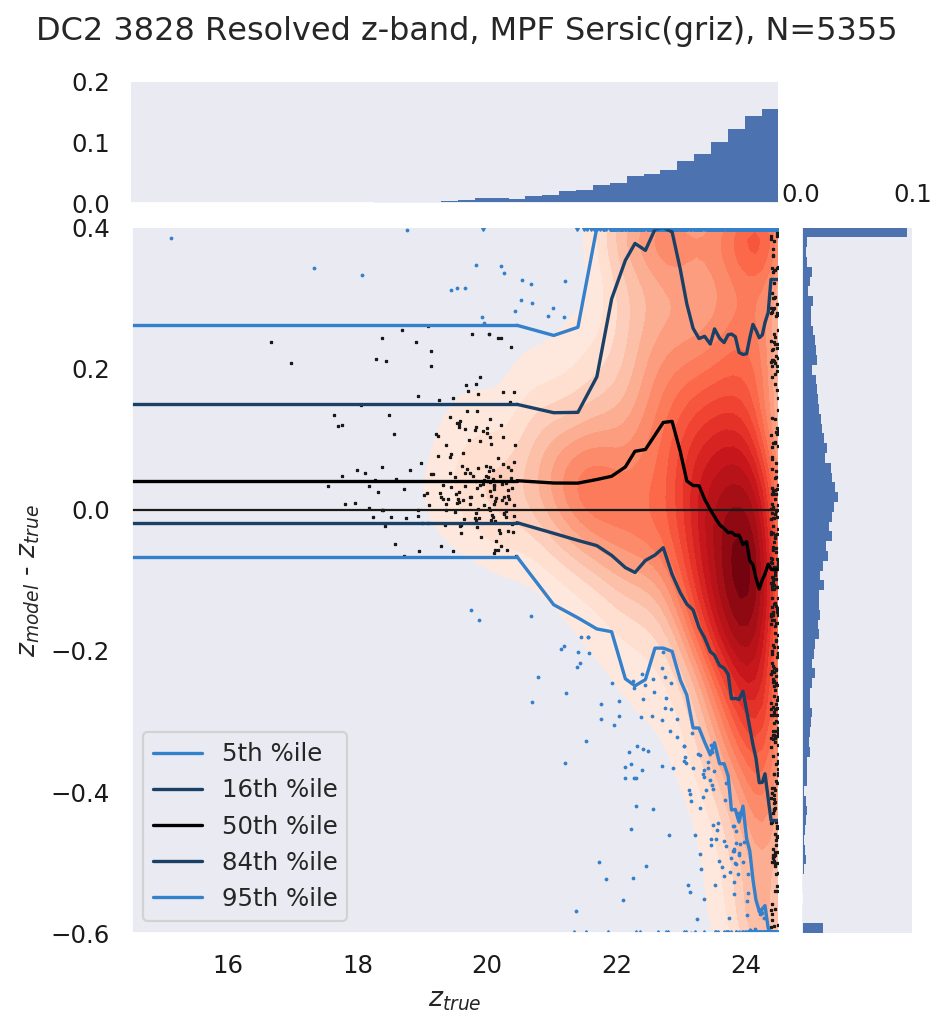

DC2 3828 Resolved g-r, MPF Sersic, N=2968


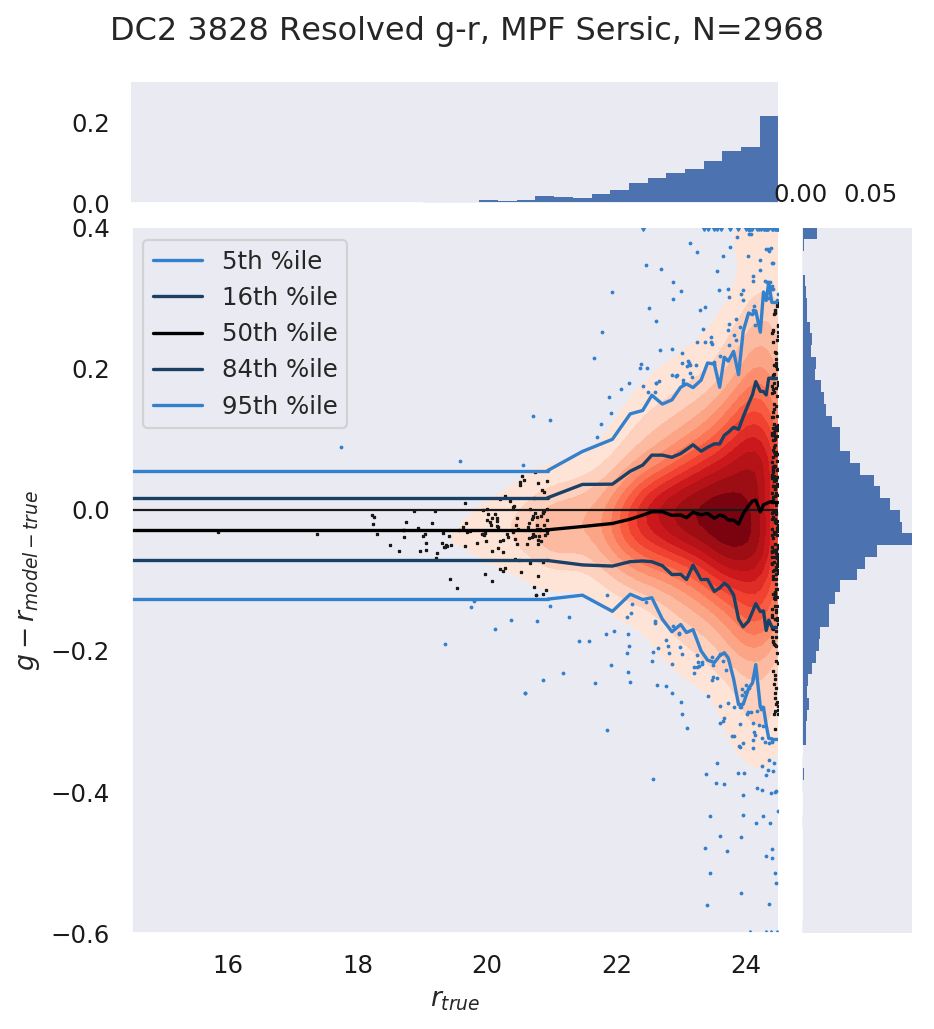

DC2 3828 Resolved g-r, MPF Sersic(griz), N=2968


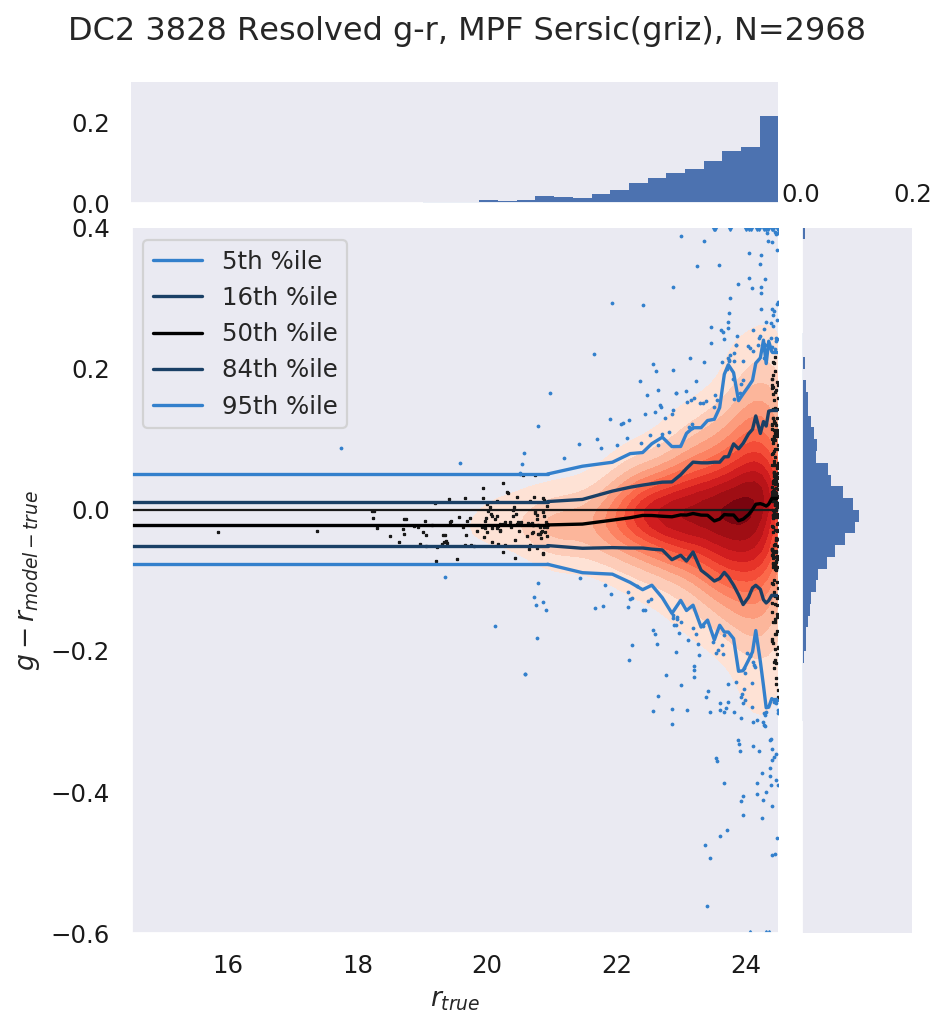

DC2 3828 Resolved r-i, MPF Sersic, N=2968


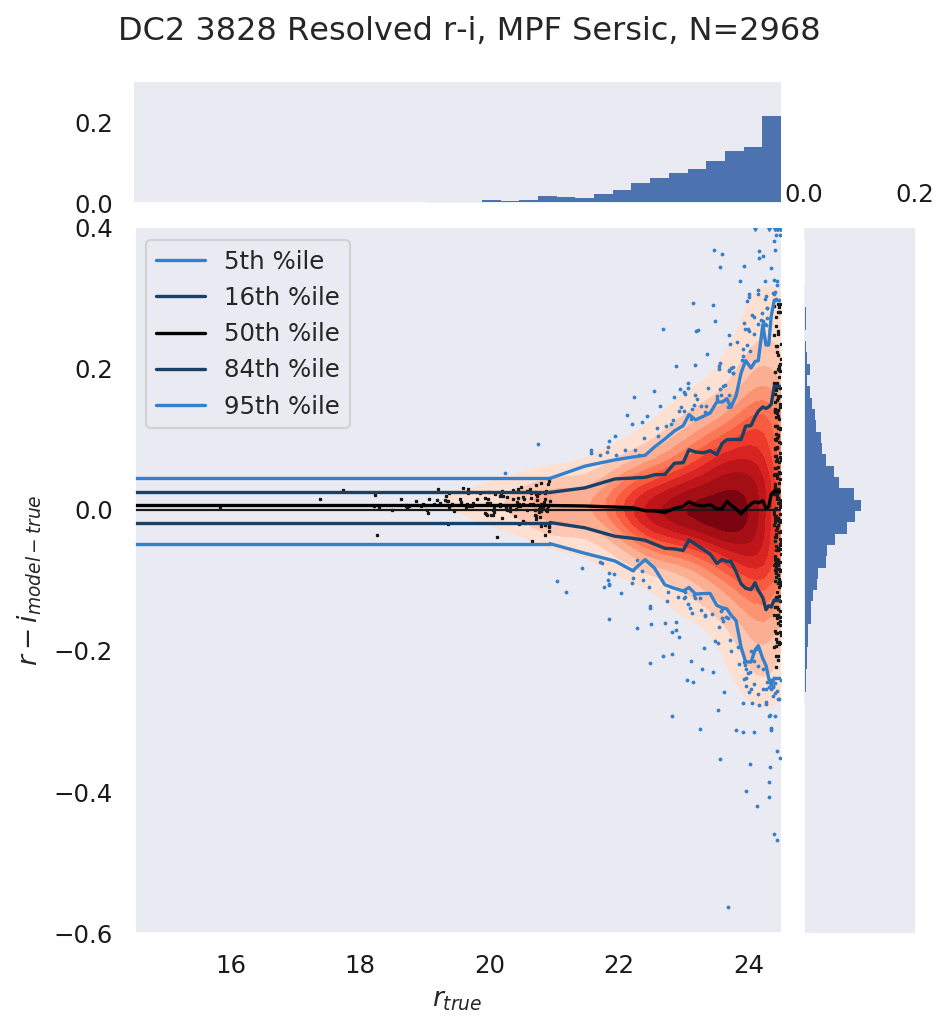

DC2 3828 Resolved r-i, MPF Sersic(griz), N=2968


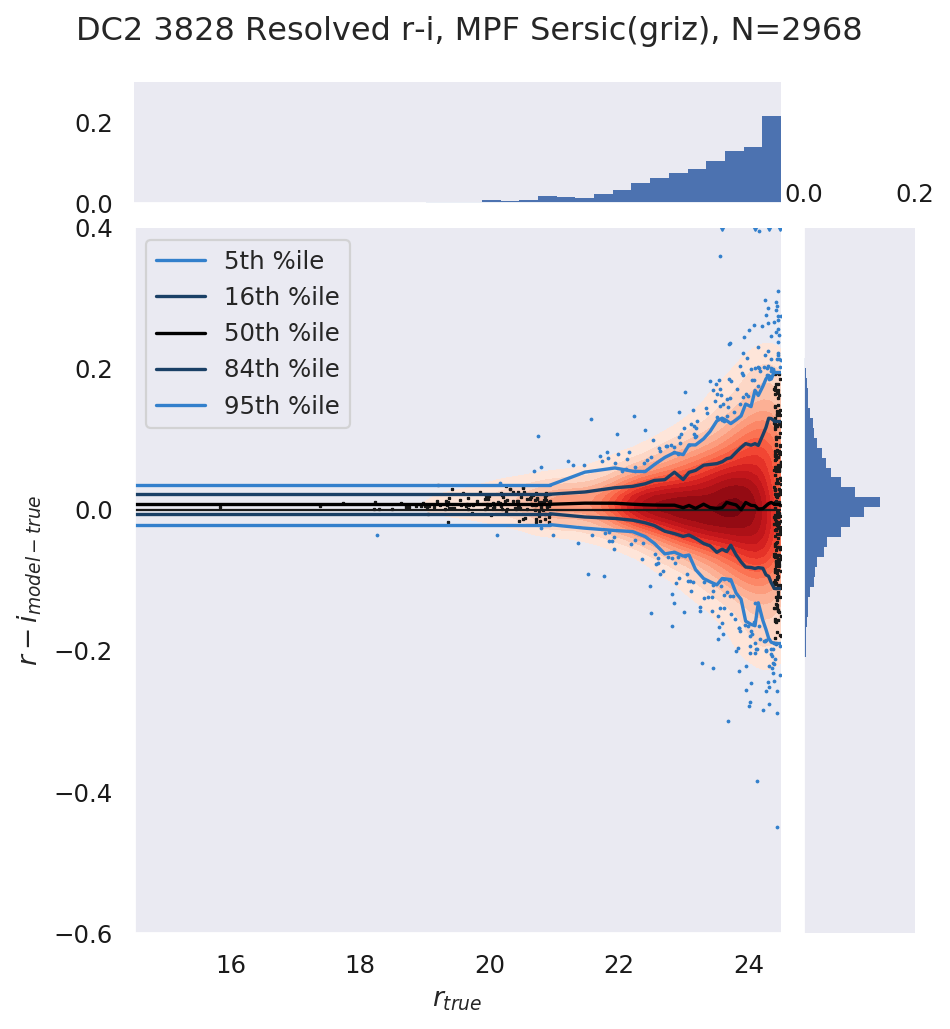

DC2 3828 Resolved i-z, MPF Sersic, N=2968


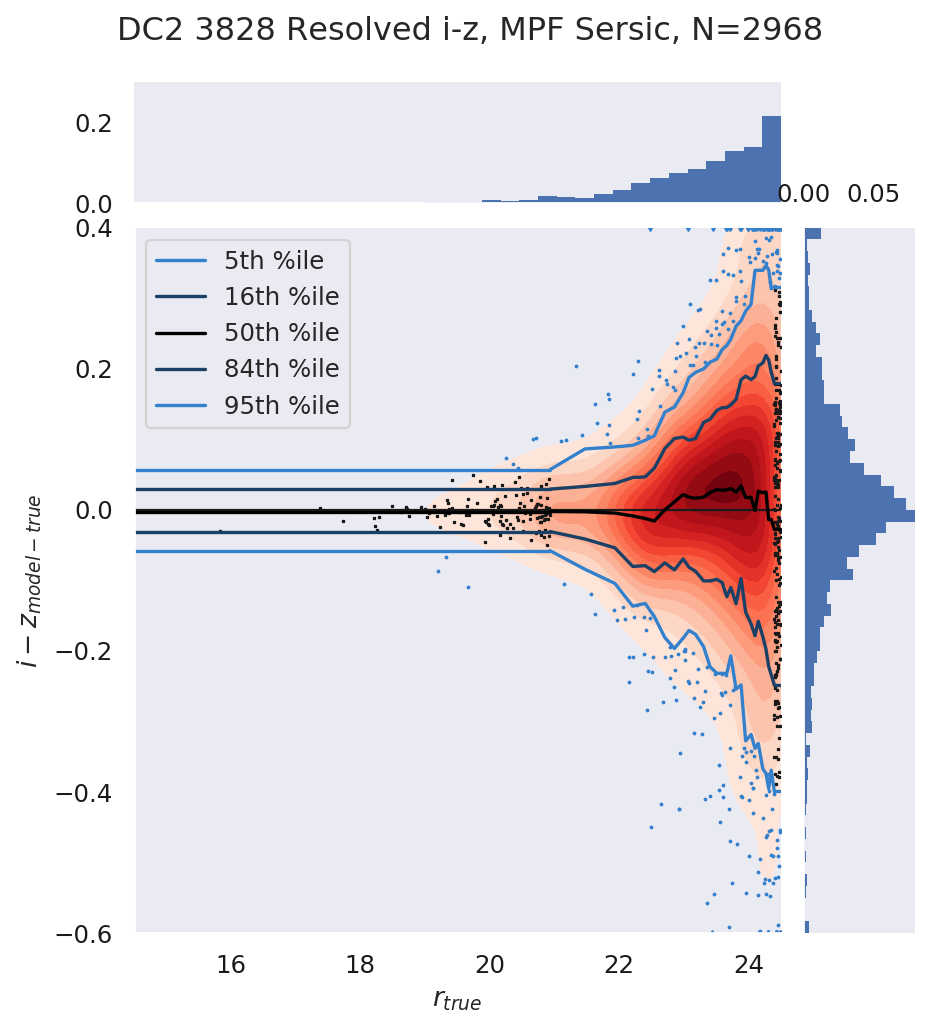

DC2 3828 Resolved i-z, MPF Sersic(griz), N=2968


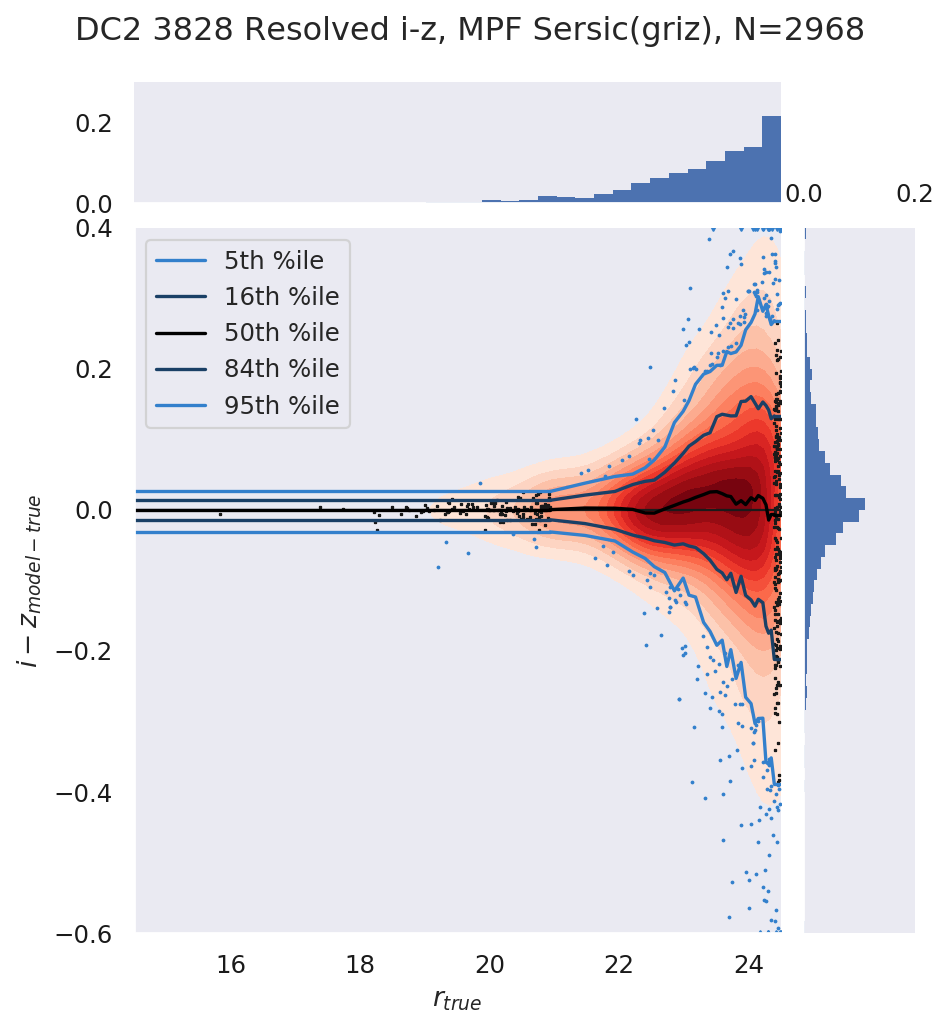

DC2 3828 Resolved g-band, Scarlet, N=1891


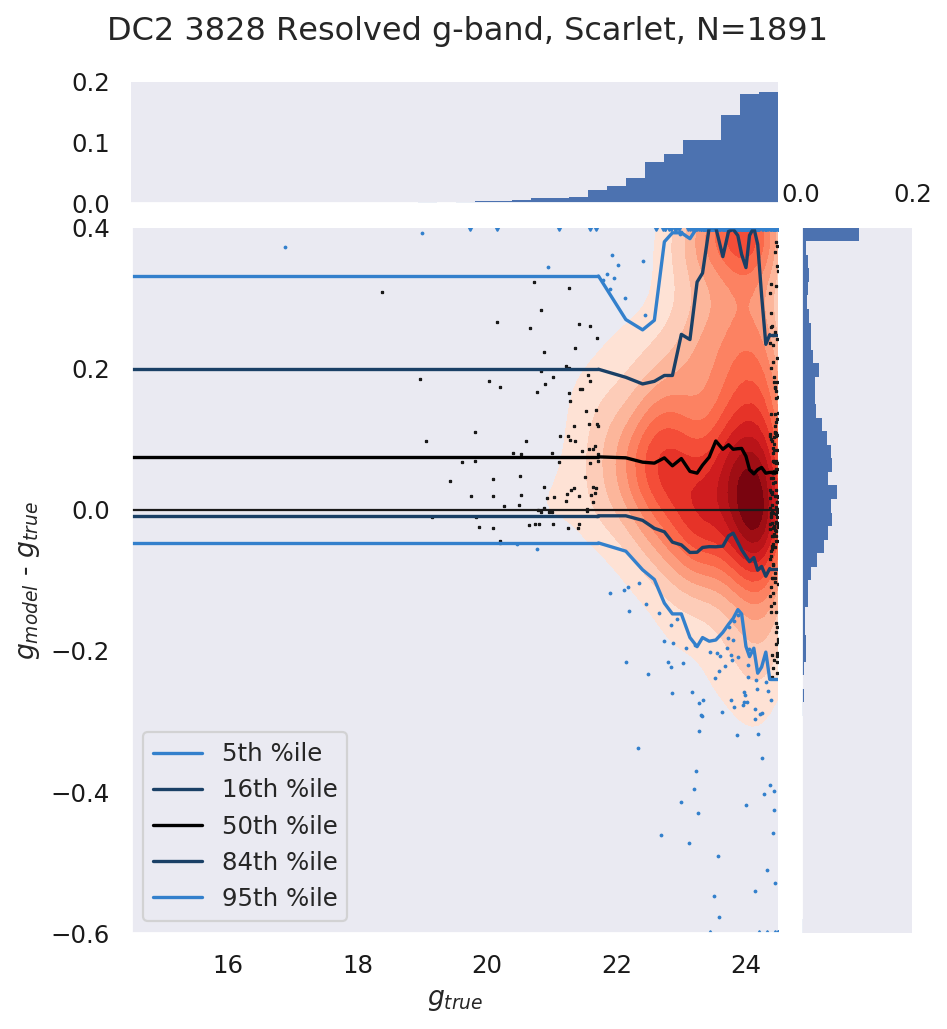

DC2 3828 Resolved g-band, Scarlet(griz), N=1891


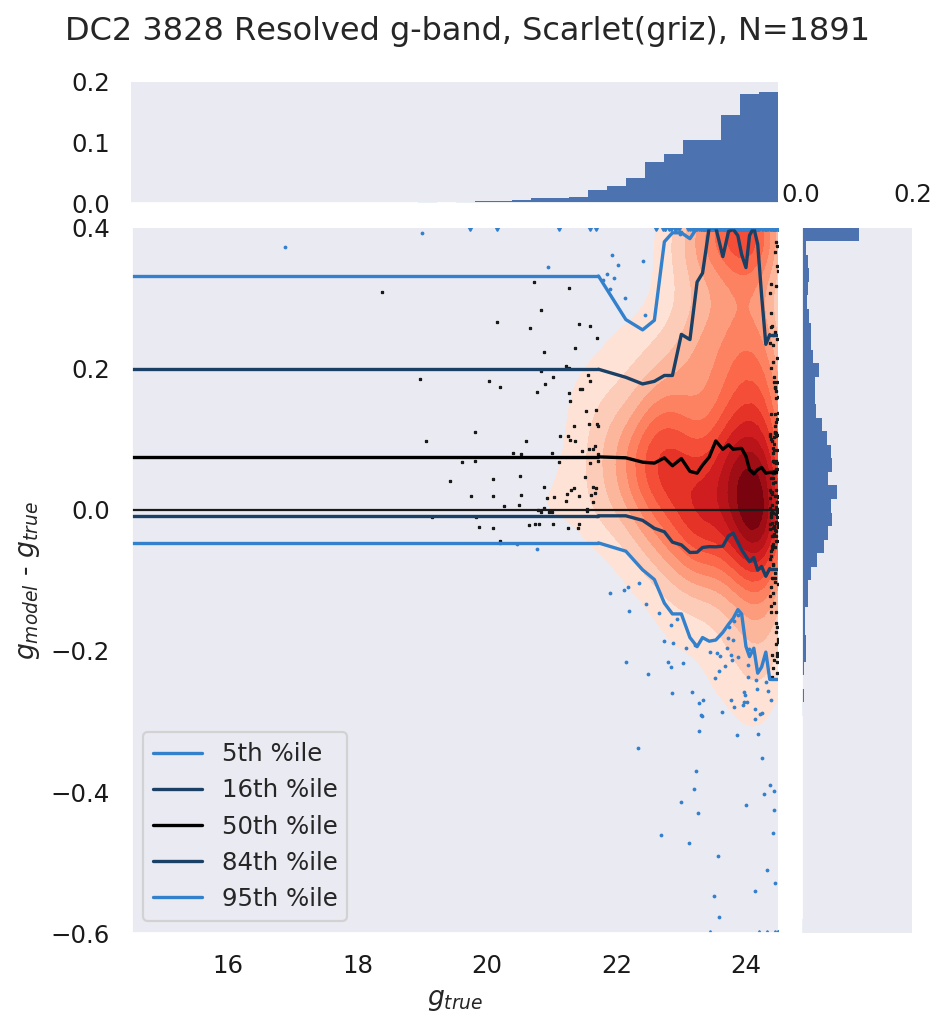

DC2 3828 Resolved r-band, Scarlet, N=2968


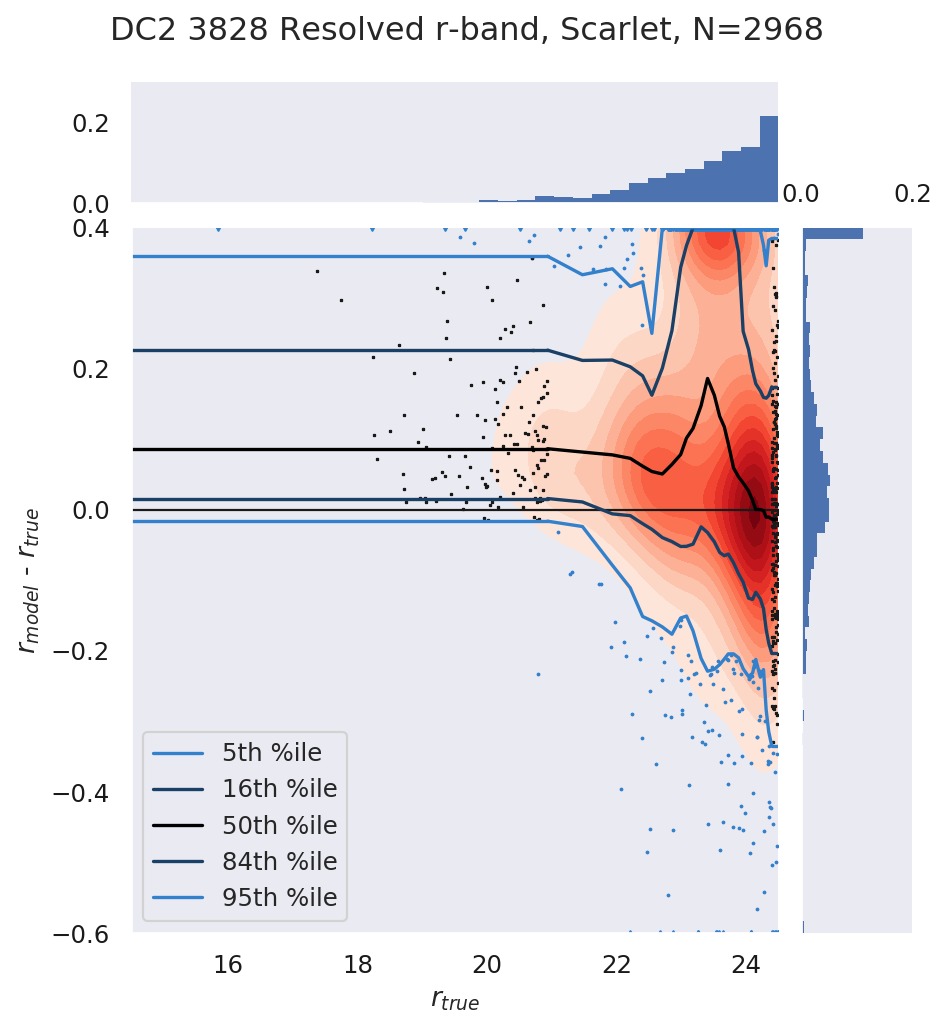

DC2 3828 Resolved r-band, Scarlet(griz), N=2968


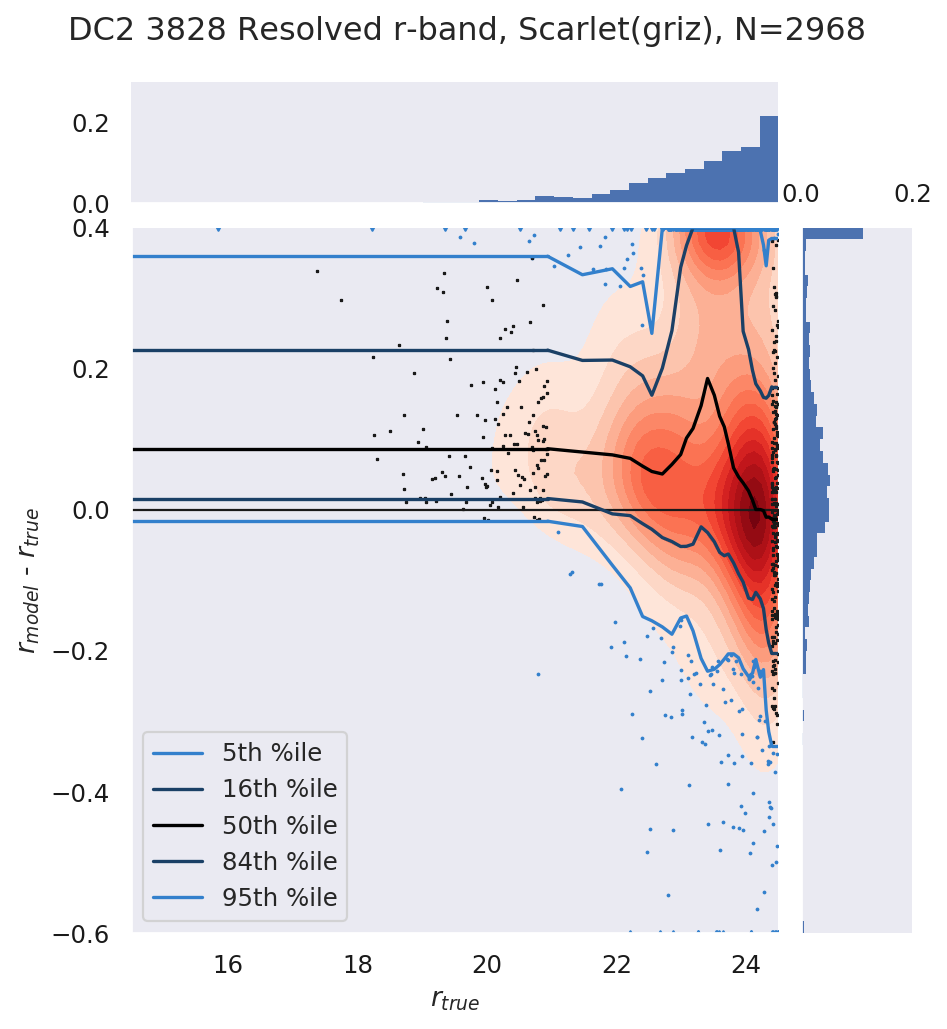

DC2 3828 Resolved i-band, Scarlet, N=4237


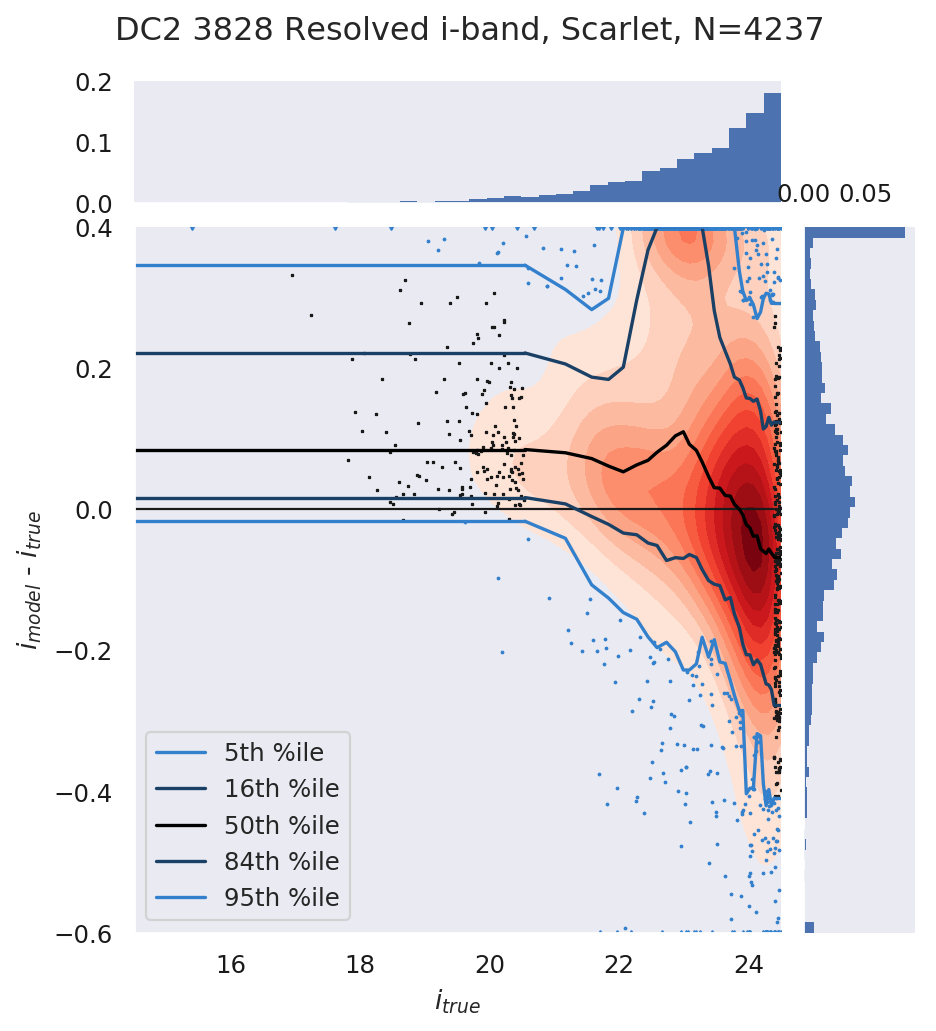

DC2 3828 Resolved i-band, Scarlet(griz), N=4237


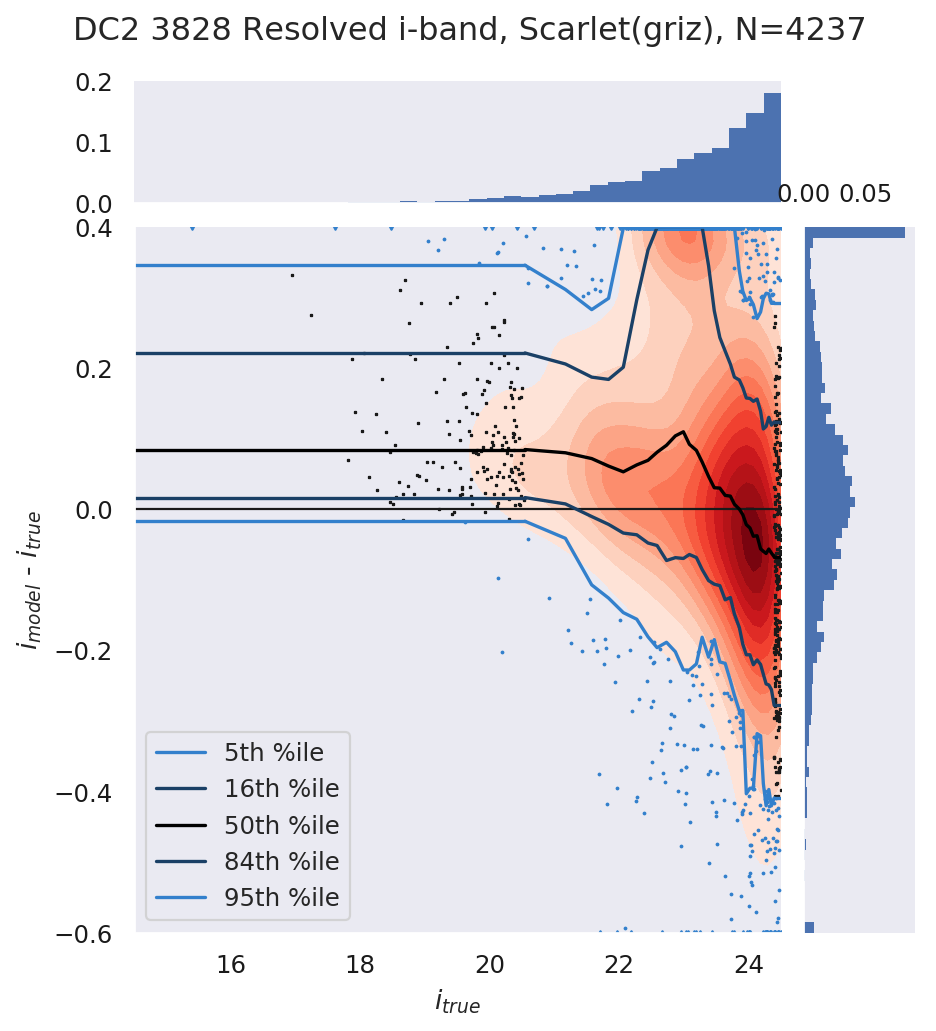

DC2 3828 Resolved z-band, Scarlet, N=5355


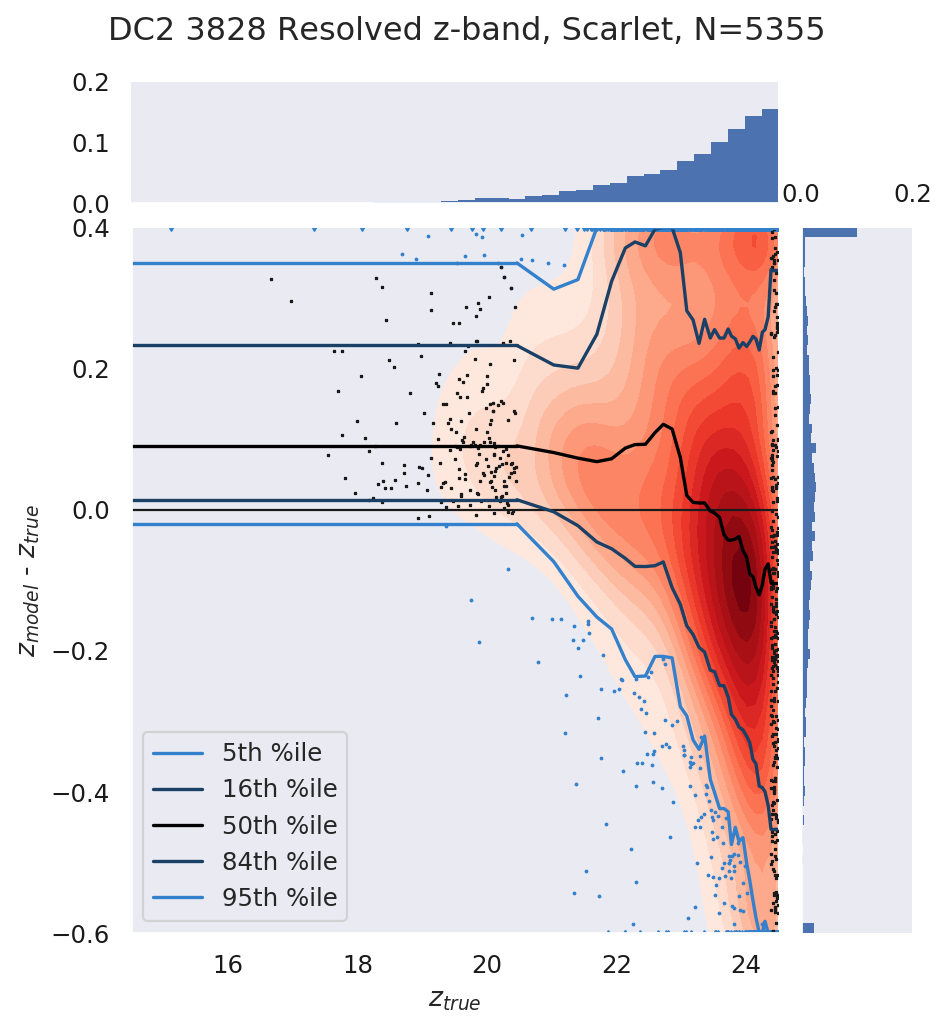

DC2 3828 Resolved z-band, Scarlet(griz), N=5355


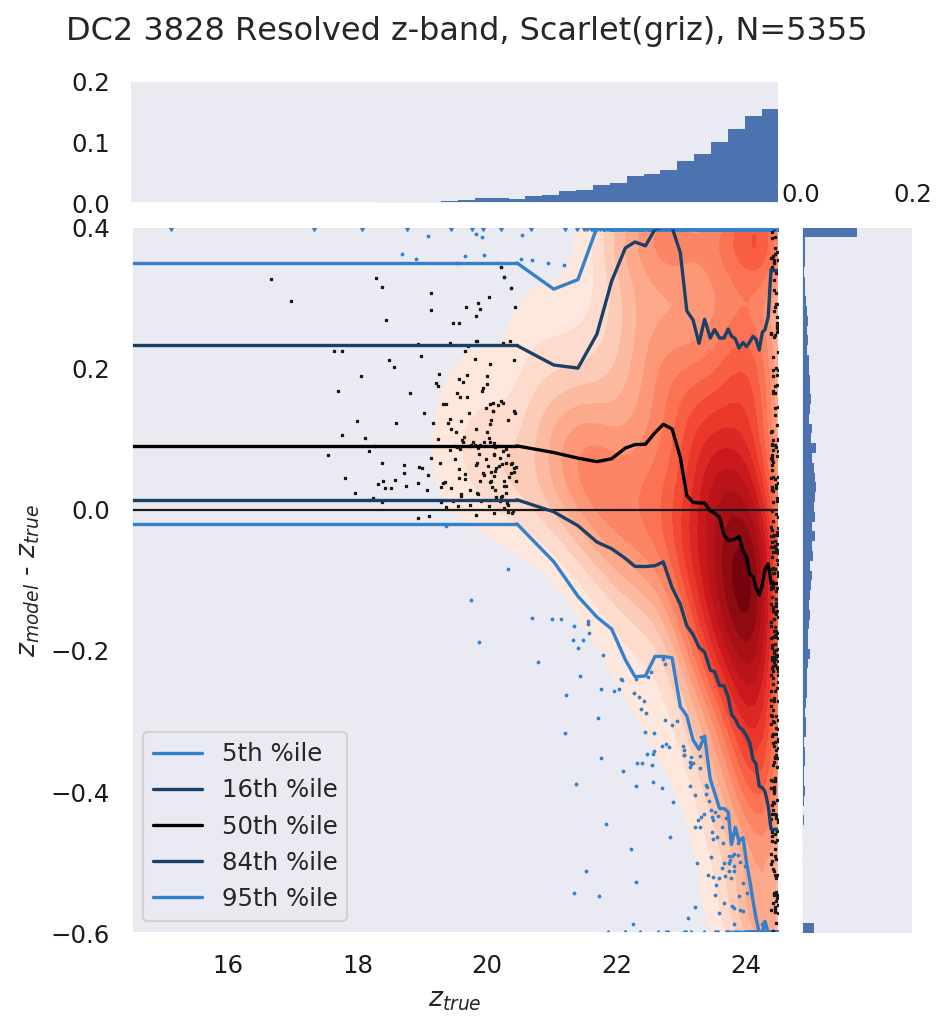

DC2 3828 Resolved g-r, Scarlet, N=2968


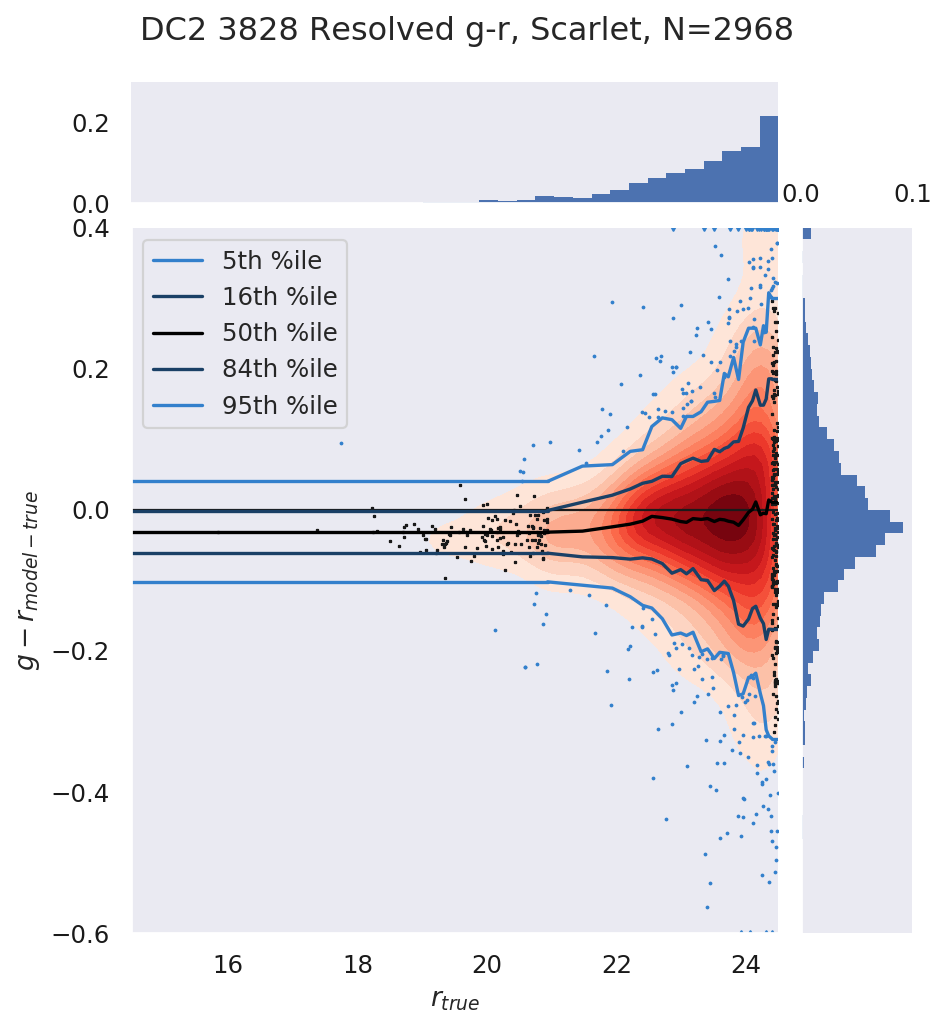

DC2 3828 Resolved g-r, Scarlet(griz), N=2968


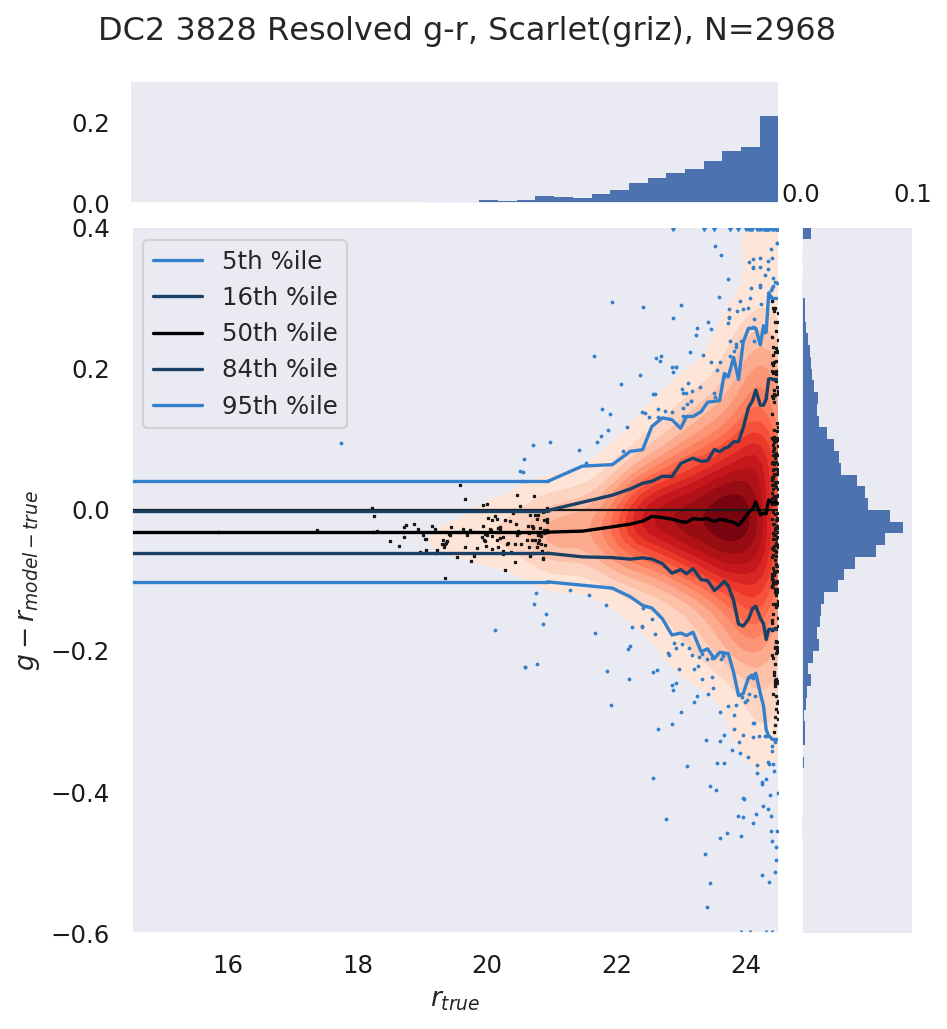

DC2 3828 Resolved r-i, Scarlet, N=2968


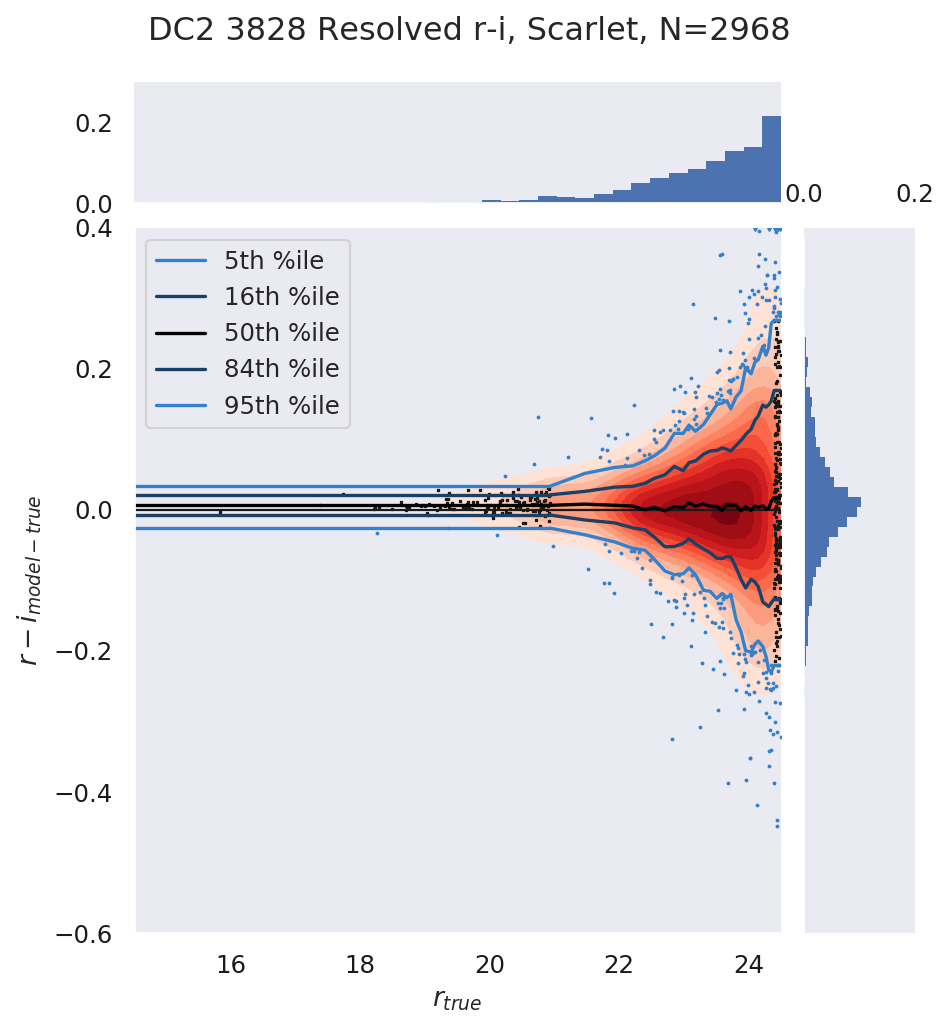

DC2 3828 Resolved r-i, Scarlet(griz), N=2968


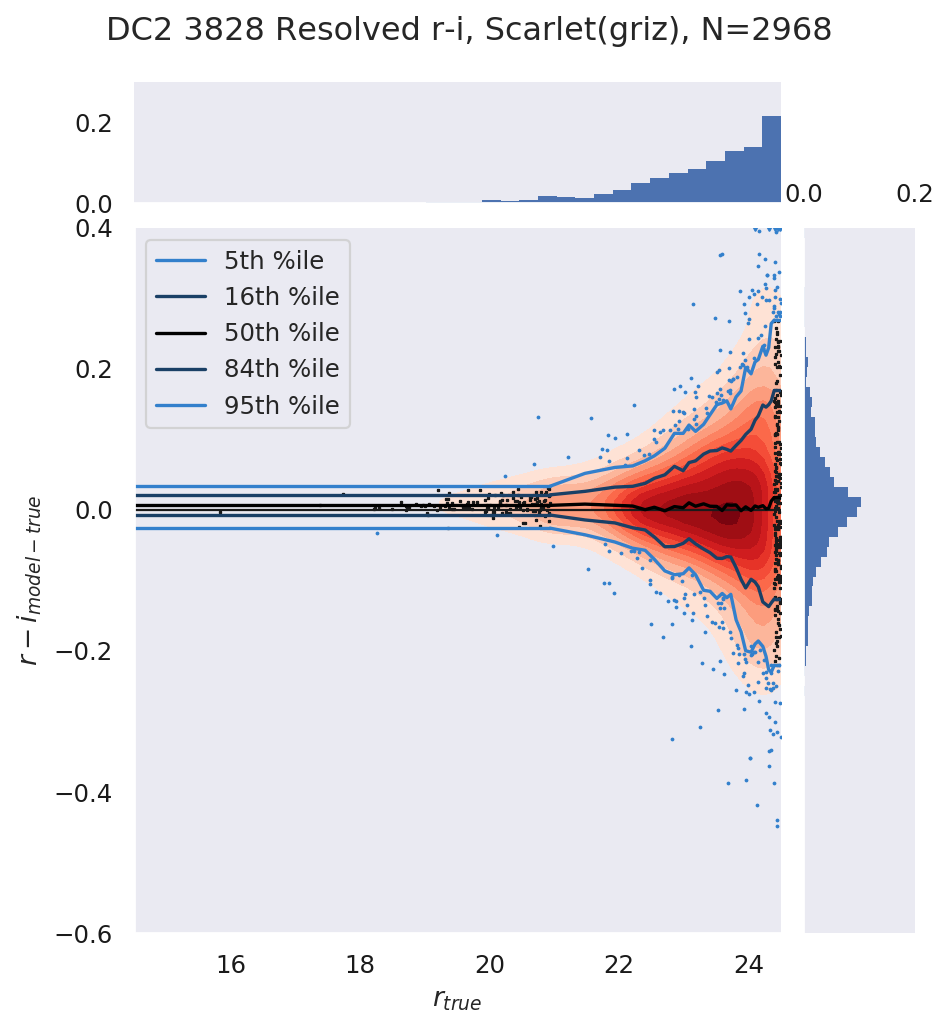

DC2 3828 Resolved i-z, Scarlet, N=2968


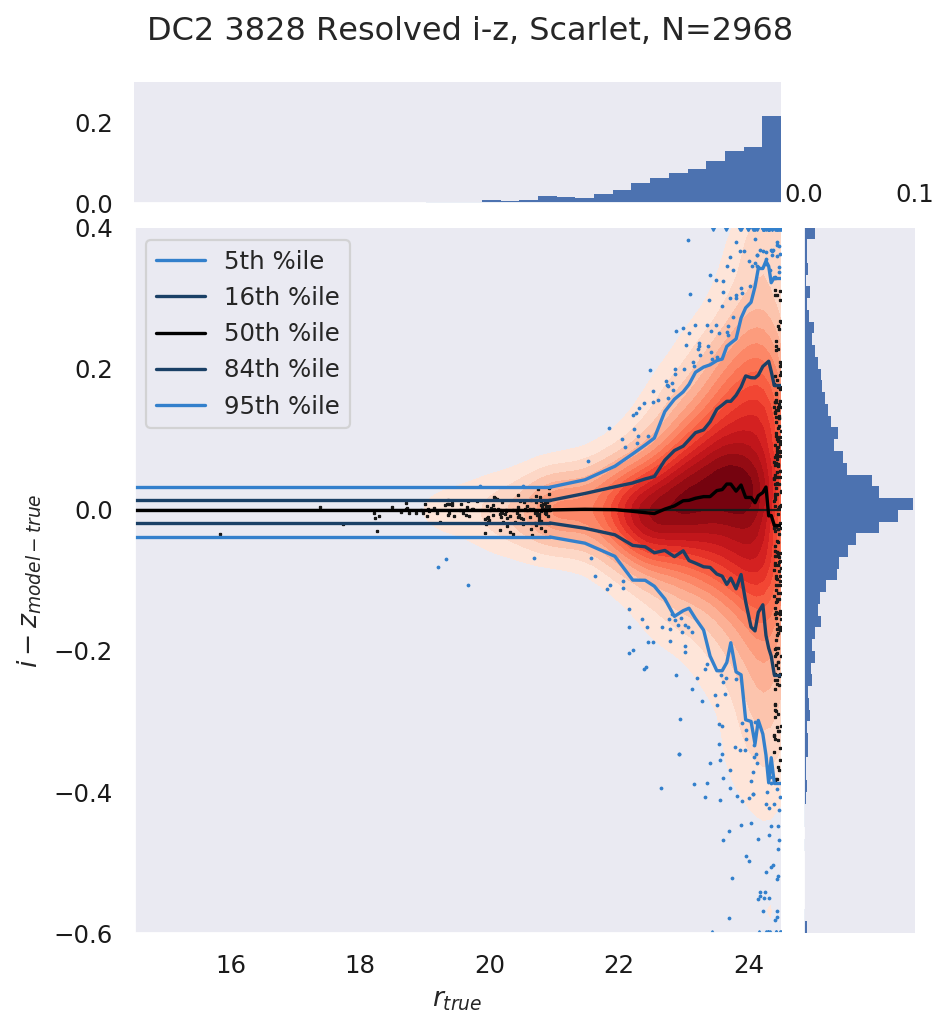

DC2 3828 Resolved i-z, Scarlet(griz), N=2968


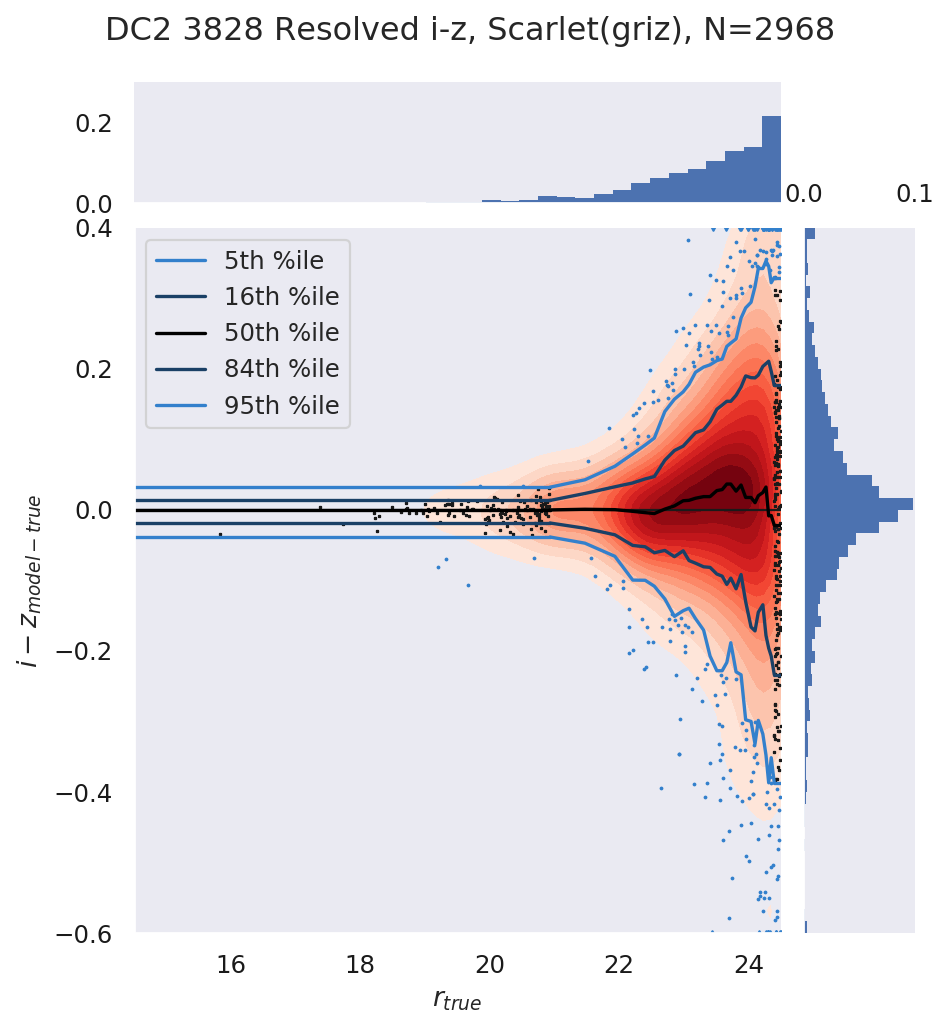

In [14]:
# Plot matches
args = dict(scatterleft=True, scatterright=True,)
args_type = {
    'resolved': {
        'limx': (14.5, 24.5),
        'limy': (-0.6, 0.4),
    },
    'unresolved': {
        'limx': (16, 23),
        'limy': (-0.08, 0.06),
    },
}
mrPlotMatches.plot_matches(
    cats_dc2['Scarlet_NR'], True, models_meas[name_scarlet], filters_single, band_ref=band_ref, band_multi='griz',
    band_ref_multi=band_ref, mag_max=24.5, match_dist_asec=0.168,
    plot_compure=False, rematch=True, **args_type['resolved'], **args
)

In [ ]:
# Turn the grid off so it doesn't show up in images
sns.set_style('dark', {'axes.grid' : False, "xtick.color": 'k', "ytick.color": 'k'})

In [ ]:
# Settings for DC2 sources in footprints
mag_min = 26
column_mag_true = f'lsst_{band_ref}_flux'
tract = 3828

In [ ]:
# Load a particular blend that has badly-behaved children (ha ha)
# Luckily all cats have the same parent, but that shouldn't be relied on
idx_parent = 404
blend = mrMeas.Blend([
    mrMeas.Deblend(cat_ref=cat_refs[name], data=catexps_n, idx_parent=idx_parent, name_deblender=name)
    for name, catexps_n in catexps.items()
])

sources_meas = {
    name_mpf: mrMeas.get_sources_meas(
        cats_mpf[name_mpf], blend.data[name_deblender].cat_ref, band_ref,
        blend.data[name_deblender].idx_children, models_meas[name_deblender],
    )
    for name_mpf, (name_deblender, *_) in namepaths.items()
}

In [ ]:
# Plot up the parent blend
bbox_xb, bbox_yb = blend.bbox.getBegin()
offset = (-bbox_xb, -bbox_yb)
measmodels = {
    'Scarlet': {'offset': offset, 'scatter_opts': dict(s=4, color='cyan', marker='+', linewidth=0.4)},
    'Base PSF': {'offset': offset, 'scatter_opts': dict(s=9, edgecolors='chartreuse', facecolors="None", marker='o', linewidth=0.4)},
}
truth = cats_dc2[name_old][tract]['truth']
sources_true = get_source_meas_all(
    bbox=blend.bbox, cat=truth, wcs=wcs_refs[name_old],
    column_mag=column_mag_true, mag_min=mag_min, zeropoint=31.4,
)
for name_deblender in butlers:
    deblend = blend.data[name_deblender]
    deblend.plot(
        bands_weights, plot_sig=True,
        sources=sources_meas[f'{name_scarlet}_NR' if name_deblender == name_scarlet else name_deblender],
        sources_true=sources_true if name_deblender == name_old else None,
        sources_sig=sources_true if name_deblender == name_scarlet else None,
        measmodels=measmodels, label_data='DC2', stretch=1, Q=12, residual_scale=0.2,
    )

In [ ]:
# Pick a misbehaving child
idx_target = 13
print(np.nonzero(deblend.is_child)[0])
print(deblend.idx_children)
for name_deblender in butlers:
    deblend = blend.data[name_deblender]
    target = deblend.children[idx_target]
    bbox_parent = deblend.parent.getFootprint().getBBox()
    bbox_child = target.getFootprint().getBBox()
    bbox_offset = bbox_child.getBegin() - bbox_parent.getBegin()
    child_width, child_height = bbox_child.getWidth(), bbox_child.getHeight()
    bbox_xb, bbox_yb = bbox_child.getBegin()
    offset = (-bbox_xb, -bbox_yb)
    measmodels_deblend = {
        'Scarlet': {'offset': offset, 'scatter_opts': dict(s=16, edgecolors='aqua', facecolors='aqua', marker='+', linewidth=1)},
        'Base PSF': {'offset': offset, 'scatter_opts': dict(s=25, edgecolors='chartreuse', facecolors='None', marker='o', linewidth=0.8)},
    }
    measmodels_fit = {
        'MPF Sersic': {'offset': offset, 'scatter_opts': dict(s=16, edgecolors='aqua', facecolors='aqua', marker='+', linewidth=1)},
    }
    sources_true_child = get_source_meas_all(
        bbox=bbox_child, cat=truth, wcs=wcs_refs[name_old],
        column_mag=column_mag_true, mag_min=mag_min, zeropoint=31.4
    )
    for measmodels_child, plot_sig in ((measmodels_deblend, False), (measmodels_fit, True):
        deblend.plot(
            bands_weights, plot_sig=plot_sig,
            sources=sources_meas[f'{name_scarlet}_NR' if name_deblender == name_scarlet else name_deblender],
            sources_true=sources_true_child if name_deblender == name_old else None,
            sources_sig=sources_true_child if name_deblender == name_scarlet else None,
            measmodels=measmodels_child, label_data='DC2', stretch=1, Q=12, residual_scale=0.2,
        )

In [ ]:
# Plot child data with nearby models subtracted, and residuals relative to zero (i.e. vs sky noise only)
if False:
    make_plots(
        imgs, img_models, bands_weights, sources=sources_meas, measmodels=measmodels_deblend,
        label_data='DC2', label_model='Scarlet sib.sub', stretch=1, Q=12, residual_scale=0.5, data_residual_factor=0
    )
    make_plots(
        imgs, img_models, bands_weights, siginvs=siginvs, sources_true=sources_input, sources=sources_meas, measmodels=measmodels_fit,
        label_data='DC2', label_model='Scarlet sib.sub', stretch=1, Q=12, residual_scale=0.5, data_residual_factor=0
    )

In [ ]:
# Now let's do it the old noiseReplacer way, leaving the previously loaded exposures untouched
exps_nr = {band: butler.get('deepCoadd_calexp', **dataId, filter=band) for band in bands_weights}
imgs_nr = {}
img_models_nr = {}
for band, exp in exps_nr.items():
    cat = cats[band]
    noiseReplacer = mil.rebuildNoiseReplacer(exp, cats[band])
    noiseReplacer.insertSource(parent['id'])
    img_model = afwImage.Image(bbox_parent, dtype='F')
    for child in children[band]:
        img_model_child, bbox_extra = mrMeas.get_spanned_image(child.getFootprint())
        img_model.subset(bbox_extra).array += img_model_child
    img_models_nr[band] = img_model[bbox_child].array
    imgs_nr[band] = exp.subset(bbox_child).image.array

In [ ]:
# The old (meas_deblender aka SDSS) deblender should be flux-conserving
make_plots(
    imgs_nr, img_models_nr, bands_weights, sources=sources_meas, measmodels=measmodels_orig,
    label_data='DC2', label_model='Scarlet NR', stretch=1, Q=12, residual_scale=1, data_residual_factor=0
)
make_plots(
    imgs_nr, img_models_nr, bands_weights, siginvs=siginvs, sources_true=sources_input, sources=sources_meas_nr,
    measmodels=measmodels_sub, label_data='DC2', label_model='Scarlet NR', stretch=1, Q=12, residual_scale=1,
    data_residual_factor=0, color_true='chartreuse'
)

In [ ]:
# Now let's do it the old noiseReplacer way to see if meas_deblender's model is any better
for band, exp in exps_nr.items():
    cat = cats[band]
    noiseReplacer = mil.rebuildNoiseReplacer(exp, cats[band])
    noiseReplacer.insertSource(target['id'])
    img_models_nr[band] = exp.subset(bbox_child).image.array

In [ ]:
# Get MultiProFit fits measured with noiseReplacer
path_nr = '/home/dtaranu/proj-dst/dc2/scarlet/2020-11-04_mpf-noiseReplacer/'
cat_mpf_nr = mrTables.read_split_cat_fits(f'{path_nr}griz/mpf_dc2_griz_3828_3,3_mag.fits')
sources_meas_nr = mrMeas.get_sources_meas(cat_mpf_nr, cat_ref, band_ref, idx_children, models_meas)

In [ ]:
# The Scarlet model with the noiseReplacer only
make_plots(
    imgs, img_models_nr, bands_weights, sources=sources_meas_nr, measmodels=measmodels_orig,
    label_data='DC2', label_model='Scarlet NR', stretch=1, Q=12, residual_scale=1, data_residual_factor=0
)
make_plots(
    imgs, img_models_nr, bands_weights, siginvs=siginvs, sources_true=sources_input, sources=sources_meas_nr,
    measmodels=measmodels_sub, label_data='DC2', label_model='Scarlet NR', stretch=1, Q=12, residual_scale=1,
    data_residual_factor=0, color_true='chartreuse'
)